# **Open Data Search & Discovery for Common Sensing**

In [4]:
# All libraries
import csv
import os, fnmatch
import urllib.request
import zipfile
import geopandas as gpd
import pandas as pd
import gzip
import glob
from multiprocessing.pool import ThreadPool as Pool
from functools import partial
from sentinelsat import SentinelAPI
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas
from shapely.geometry import Polygon
from shapely import wkt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import platform
import numpy as np
from osgeo import ogr, osr
import datetime

import requests
import json
import getpass

%matplotlib inline

# Executive Summary

Broad bbox used over Fiji for Search & Discovery in aid of defining Common Sensing PoC.

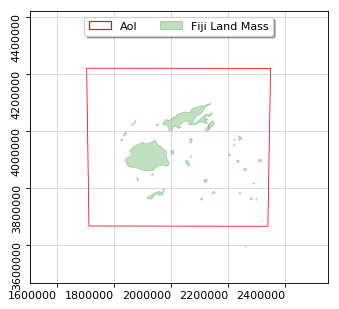

In [5]:
# wkt used for querying APIs
wkt_aoi = "POLYGON((176 -15,-178 -15,-178 -20,176 -20,176 -15))"

# geopandas dataframe for plotting
aoidf = pd.DataFrame(data={'geometry': [wkt_aoi]})
aoidf['geometry'] = aoidf['geometry'].apply(wkt.loads)

# reporojected into Fiji-specific crs to overcome anti-meridian overlap. Uses custom reporject function.
aoidf['repro'] = aoidf['geometry'].apply(lambda x: reproject(str(x)))
aoidf['repro'] = aoidf['repro'].apply(wkt.loads)
aoigdf = geopandas.GeoDataFrame(aoidf, geometry='repro', crs=('epsg:3460'))

# load Fij Borders shapefile
borders = geopandas.read_file('../Search_Discovery/AoIs/Fiji_Borders_fijimapgrid.geojson')

# plot query AoI over Fiji borders (world borders)
fig, ax = plt.subplots(figsize=(5,5),dpi=80)
fig.autofmt_xdate()

leg_patches=[]

# plot AoI
aoigdf.plot(facecolor="none", edgecolor='r', lw=0.7, ax=ax);
leg_patches.append(mpatches.Patch(facecolor='none',edgecolor='red', label='AoI'))
# plot borders
borders.plot(facecolor="g", edgecolor='g', alpha=0.25, lw=0.7, ax=ax);
leg_patches.append(mpatches.Patch(facecolor='g',edgecolor='g', alpha=0.25, label='Fiji Land Mass'))

# Consistent plotting settings
ax.legend(handles=leg_patches, loc='upper center', shadow=True, ncol=5);
ax.grid(alpha=0.5);
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);
ax.set_xlim(aoigdf.bounds.minx.values[0]-200000, aoigdf.bounds.maxx.values[0]+200000);
ax.set_ylim(aoigdf.bounds.miny.values[0]-200000, aoigdf.bounds.maxy.values[0]+200000);

Sentinel-1 SLC coverage is comprehensive and can be readily obtained via ASF. (*insert image ticks timeseries plus frame outlines.*)

Sentinel-2 L1C coverage is ... Landsat-1-8 coverage is generally sparse in the archive but comprehensive with Landsat-8. ARD should be ordered on demand directly from USGS. (*insert image ticks timeseries of cloud cover PLUS path-row and granule outlines*.)

Tabular breakdown of data volumes & storage for each source.

Summary recommendations

# Introduction & Context

Establishing an effective method for accessing publicly-available satellite imaging missions is an essential requirement for large-scale spatial-temporal mapping applications. The advent of Geospatial Platorms that make it possible to serve data from these missions to the mass market, alongside abundant computational and analytical resources, has only increased pressure on the custodians of these datasets to disseminate them in both a **readily accessible** and **readily usable** format.

The lead time for custodians to practically adopt concepts such as **Analysis Ready Data** (ARD) has been significant, with routines for appropriately correcting even basic effects continuing to be disputed years after data becoming available and efficiencies in their implementation still to be robustly improved. Within this absence of practical action, a wide variety of scientific and non-scientific stakeholders have invested in creating myriad open source and proprietary algorithmic and processing solutions for overcoming  the prohibitive nature of dense semi-usable datasets available at scale. Any such investments offer only a short term solution to a persistent challenge and pose significant risk of redundancy due to the invitable core dissemination of ARD products by custodians themselves; initially for easily interpretable optical datasets and eventually the more complex SAR datasets.

Any operational system being designed to exploit satellite image products must recognise the changing landscape during the timeframe within which is shall become established and ensure resilience against potential redundancy and duplication.


# Data Access & Processing Considerations

***Sensor-specific considerations and conclusions***

**Sentinel-1**

Sentinel-1 (S1) is a SAR data source meaning we **do not need to consider cloud cover**. Determining the no. acquisitions across **orbit direction** (ascending vs descending) and **platform** (A vs B) is important due to the inherently complex nature of SAR backscatter products obtained from differing acquisition geometries. Core distribution of S1 data is from ESA at GRD or SLC processing levels. Processing from **SLC is considered more robust** than from GRD and offers the potential for generating complex ARD products in addition to just backscatter intensity. While SLC products are a much greater file size, these only need to be handled ahead of generating the much lighter backscatter products. Downloading S1 data from ESA API is capped to a limited no. concurrent requests. **ASF is typically utilised in the place of ESA** due to the absence of a cap and believed 'mirroring' of the ESA S1 data archive. The **consistency with which the archive is mirrored for SLC and GRD products is unknown**.

Generating backscatter intensity ARD products from S1 SLC via ASF can be undertaken using any compatible SAR processing software. There is a severe absence of quantitative evidence determining the influence of software choice on quality of the final backscatter product. This is an open and active subject in the community. Typically users choose between SNAP (open source) and Gamma (proprietary) software. We shall utilise SNAP due to being openly available and ESA-driven.

The broader community has agreed the basic recipe for S1 backscatter ARD products (via CEOS) however ESA has not committed to dissemintating these centrally. It is imperative that Common Sensing actively monitors ESA's stance on this topic. Any central dissemination by ESA risk Common Sensing ARD generation as redundant. ASF have released prototype ARD products available on-demand. These have not been tested for quality and are not routinel available. Commons Sensing should also actively monitor this progress and evaluate its cost saving potential. 

Lack of a core disseminated product means there is limited development of DC indexing scripts for S1 and effort will be required internally to index the products that we generate ourselves.

**Sentinel-2**

Sentinel-2 (S2) is an optical data set  and its high-temporal frequency and spatial resolution likely makes it the most challenging data source of the project. It may be tempting to only download and utilise S2 scenes that are above a certain threshold of cloud-free. Taking this approach, however, overlooks one of the most important features of working with optical imagery within a DC environment; the potential for generating cloud-free composite mosaics. Catapult should only utilise a cloud cover % filter if absolutely necessary from a storage and compute resources perspective, and when doing so must make an informed decision based upon the distribution of cloud cover within the S2 archive.

Access to S2 data is possible centrally via ESA. There are two processing levels available; L1C and L2A. L2A is atmospherically corrected and considered an ARD product (BRDF aside).

**Landsat-1-8**

Steal from USGS...


# Specific Scope

We collate Search & Discovery outputs for openly available high-resolution satellite datasets to support Catapult decision making on the following components of the 3-year Common Sensing project:
- What volume of data is available across each data source required by the project?
    - Backlog vs operational storage reqs.
    - Backlog vs operation compute reqs.
- What is the most effective access method?
    - Routines for querying & downloading via appropriate APIs
- Is a Common Sensing workflow required to generate ARD?
    - Resource allocation recs.
- Are there any unknown challenges that can be uncovered through a comprehensive understannnding of data availability?
    - Mode availability?
    - Time of day availability?
    - Data frame shifts?
    - etc.
    
Data sources considered:
- Sentinel-1
- Sentinel-2
- Landsat-1-8
- [Sentinel-3]
- [Sentinel-5p]

## Notes

https://github.com/olivierhagolle/Sentinel-download/blob/master/README.md
https://sentinelsat.readthedocs.io/en/stable/

Sentinel-2 now routinely available from ESA - using sen2cor
Legacy Sentinel-2 ARD not currently available anywhere for Fiji. This is unlikely to change, with ESA maintaining L2A within a rolling 30 day archive.


Landsat ARD not available routinely anywhere.

Landsat USGS split into pre-collection and post-collection

https://github.com/olivierhagolle/LANDSAT-Download
https://github.com/developmentseed/landsat-util
USGS ARD handbook - https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/LSDS-1873_US_Landsat_ARD_DFCB_0.pdf


- USGS Acquisitions csvs - https://landsat.usgs.gov/download-entire-collection-metadata
- USGS BDA API - https://github.com/USGS-EROS/espa-api#user-api
- USGS path / row shapefiles - https://landsat.usgs.gov/pathrow-shapefiles

# Sentinel-1 Detailed Assessment

### **Query:** Alaska Satellite Facility, ESA Open Access Hub(, Sedas tbc)
Where can we find the data, let's convert api results to .csv.

In [4]:
# Query ASF (SLC).
!curl https://api.daac.asf.alaska.edu/services/search/param?intersectsWith=polygon\(\(176,-15,-178,-15,-178,-20,176,-20,176,-15\)\)\&platform=SA,SB\&processingLevel=SLC\&output=csv > ../Search_Discovery/Fiji_S1_SLC_ASF.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  530k    0  530k    0     0   124k      0 --:--:--  0:00:04 --:--:--  124k


In [5]:
# Query ASF (GRD). TO BE CORRECTED - PRODCTS???????
!curl https://api.daac.asf.alaska.edu/services/search/param?intersectsWith=polygon\(\(176,-15,-178,-15,-178,-20,176,-20,176,-15\)\)\&platform=SA,SB\&processingLevel=GRD_HD\&output=csv > ../Search_Discovery/Fiji_S1_GRD_ASF.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  314k    0  314k    0     0    98k      0 --:--:--  0:00:03 --:--:--   98k


In [7]:
# Query ESA Open Access Hub
esa_api = SentinelAPI('tmj21','Welcome12!')
res = esa_api.query(wkt_aoi,platformname='Sentinel-1',producttype='SLC')
esa_api.to_geodataframe(res).to_csv('../Search_Discovery/Fiji_S1_SLC_ESA.csv')
res = esa_api.query(wkt_aoi,platformname='Sentinel-1',producttype='GRD')
esa_api.to_geodataframe(res).to_csv('../Search_Discovery/Fiji_S1_GRD_ESA.csv')

Querying products: 100%|██████████| 676/676 [00:16<00:00, 41.10 products/s]


### **Determining a suitable data source:** Alaska Satellite Facility, ESA Open Access Hub(, Sedas tbc)

***Are there consistent data volumes across data sources and processing levels?***
- Can we be confident in routinely accessing SLC products from ASF in an operational scenario beyond the project timeframes?
- What would be the fastest method for accessing SLC products for processing the full archive within the project timeframes?

Determining monthly data volumes across each source for each product gives a fair representation of how consistent the 'mirror' sites re-distribute the products to be used within the project. 

Findings
- A consistent SLC archive is found at ASF up until approx. March 2019.


Recommendations
- ASF looks to be a robust source for **archive** S1 SLC products up until approx. March 2019.

Further questions
- What is the cause of the significant increase in data volume post-March 2019?
- Why are GRD products from ASF consistently unavailable?


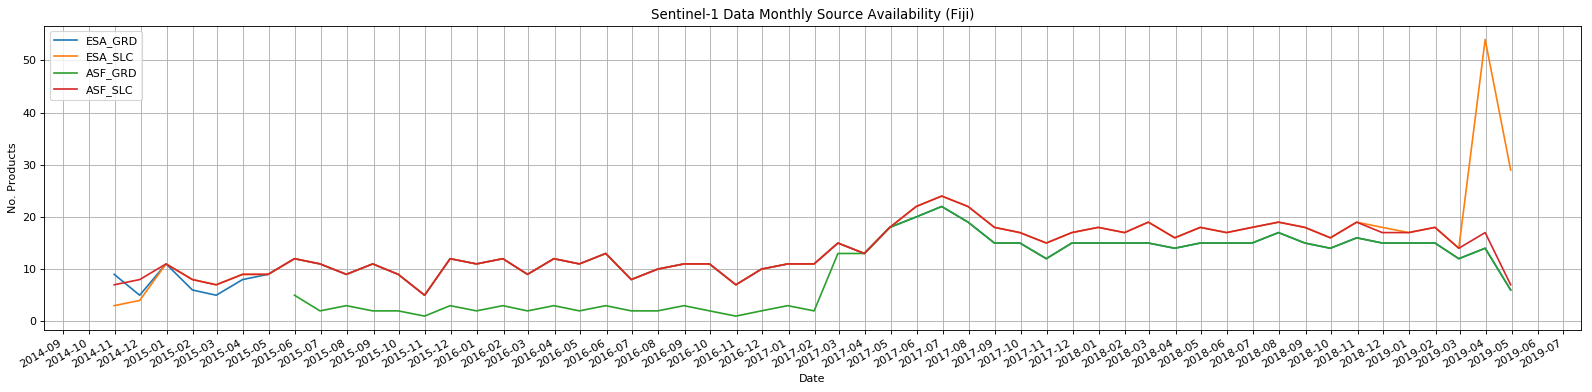

In [155]:
# Create monthly data availability plot from each data source.
fig, ax = plt.subplots(figsize=(20,5),dpi=80)
fig.autofmt_xdate()

df = pd.read_csv('../Search_Discovery/Fiji_S1_GRD_ESA.csv')
#print('ESA GRD \n', 'No. Prods: ', len(df))
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%dT%H:%M:%S', utc=True)
# Convert dates into datetime objects
df['Acquisition Date'] = pd.to_datetime(df['Acquisition Date'], format='%Y-%m-%dT%H:%M:%S', utc=True)
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').valuesData Estimates Over Fiji

%load_ext autoreload

%autoreload 2



import geopandas as gpd

​
ax.plot(df.index.to_timestamp(freq ='M').values, df.values);

df = pd.read_csv('../Search_Discovery/Fiji_S1_SLC_ESA.csv')
#print('ESA SLC \n', 'No. Prods: ', len(df))
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%dT%H:%M:%S', utc=True)
# Convert dates into datetime objects
df['Acquisition Date'] = pd.to_datetime(df['Acquisition Date'], format='%Y-%m-%dT%H:%M:%S', utc=True)
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values);

df = pd.read_csv('../Search_Discovery/Fiji_S1_GRD_ASF.csv')
#print('ASF GRD \n', 'No. Prods: ', len(df), 'Vol Prods (TB): ', df['Size (MB)'].sum()/1000000)
# Convert dates into datetime objects
df['Acquisition Date'] = pd.to_datetime(df['Acquisition Date'], format='%Y-%m-%dT%H:%M:%S', utc=True)
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values);

df = pd.read_csv('../Search_Discovery/Fiji_S1_SLC_ASF.csv')
#print('ASF SLC \n', 'No. Prods: ', len(df), 'Vol Prods (TB): ', df['Size (MB)'].sum()/1000000)
# Convert dates into datetime objects
df['Acquisition Date'] = pd.to_datetime(df['Acquisition Date'], format='%Y-%m-%dT%H:%M:%S', utc=True)
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values);

#'bD-.'
ax.set_ylabel("No. Products");
ax.set_xlabel("Date");
#ax.set_ylim(0,40)
ax.legend(['ESA_GRD','ESA_SLC','ASF_GRD','ASF_SLC'], loc='upper left');
#ax.legend.loc('upper left')
ax.set_title('Sentinel-1 Data Monthly Source Availability (Fiji)');
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m") ) 
ax.grid();
fig.tight_layout();
fig.savefig('../Search_Discovery/Fiji_S1_Monthly_Source_Availability');

***What is causing the recent discrepency between ASF and ESA SLC availability?***

SLC products only considered due to suitability and inconsistent differences in archives of GRD across ESA and ASF.

Focusing on just the timeframe of interest we can plot the specific acquisition times from all products and explore any factors that may be influencing the discrpencies.

- Consistent archives, determined by near-exact 'acquisition time' (ASF) and 'begin position' (ESA) and presented as intersecting ticks, exist for the vast majority of the S1 archive.
- Discrpencies only appear within the most recent period (2 months or so).

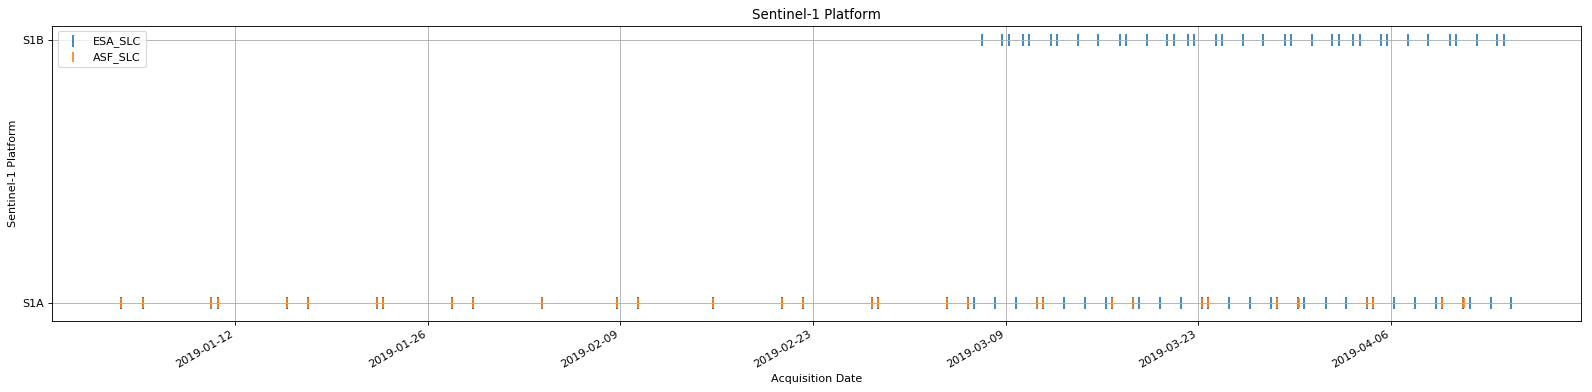

In [180]:
import datetime

fig, ax = plt.subplots(figsize=(20,5),dpi=80)
fig.autofmt_xdate()

df = pd.read_csv('../Search_Discovery/Fiji_S1_SLC_ESA.csv')
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)
df['s1platform'] = df['identifier'].str[:3]
df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2020,1,1))]
ax.scatter(df['Acquisition Date'].values, df['s1platform'].values, marker='|',s=100);

df = pd.read_csv('../Search_Discovery/Fiji_S1_SLC_ASF.csv')
df['Acquisition Date'] = pd.to_datetime(df['Acquisition Date'], format='%Y-%m-%d', utc=True)
df['s1platform'] = df['Granule Name'].str[:3]
df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2020,1,1))]
ax.scatter(df['Acquisition Date'].values, df['s1platform'].values, marker='|',s=75);

ax.set_ylabel("Sentinel-1 Platform");
ax.set_xlabel("Acquisition Date");
ax.legend(['ESA_SLC','ASF_SLC','USGS_L4-5TM','USGS_L1-4MSS']);
ax.set_title('Sentinel-1 Platform');
ax.xaxis.set_major_locator(mdates.AutoDateLocator());
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d") ); 
#ax.xaxis.set_minor_locator(mdates.MonthLocator());
#ax.xaxis.set_minor_formatter(DateFormatter("%Y-%m") ); 
ax.grid(which='both')
fig.tight_layout()
fig.savefig('../Search_Discovery/Fiji_S1_tempdistribution_orbitdirection');

Investigating characteristics of discrepencies shows that the increased no. acquisitions include both S1A and S1B, both ascending and descending however **ONLY WV acquisition mode**.

- It's unlikely that CS will want to exploit WV datasets due to being primarily for maritime applications. Any other reason?
- The large volume of WV datasets may pose useful in the future. Particularly for Islands not covered by S1 IW mode.
- WV products may have appeared as results within the query accidently and not have any actualy relevant data within the overlaying vignettes.

In [70]:
# subset ESA df to mirrored products

df = pd.read_csv('../Search_Discovery/Fiji_S1_SLC_ASF.csv')
df['Acquisition Date'] = pd.to_datetime(df['Acquisition Date'], format='%Y-%m-%d', utc=True)
df['s1platform'] = df['Granule Name'].str[:3]
df['Name'] = df['Granule Name']
names = df['Name'].values

df = pd.read_csv('../Search_Discovery/Fiji_S1_SLC_ESA.csv')
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)
df['s1platform'] = df['identifier'].str[:3]
df['Name'] = df['title']
df = df[~df['Name'].isin(names)]

print('Characteristics of data not mirrored by ASF')
print('No. inconsistent: ', len(np.unique(df.Name)))
print('Unique platform: ', np.unique(df.s1platform))
print('Unique polarisation: ', np.unique(df.polarisationmode))
print('Unique orbit direction: ', np.unique(df.orbitdirection))
print('Unique orbit direction: ', np.unique(df.sensoroperationalmode))

Characteristics of data not mirrored by ASF
No. inconsistent:  60
Unique platform:  ['S1A' 'S1B']
Unique polarisation:  ['VV']
Unique orbit direction:  ['ASCENDING' 'DESCENDING']
Unique orbit direction:  ['WV']


Summary of WV mode coverage showing how results may potentially be erroneous due to non-specifc gemetries held be ESA for these products.

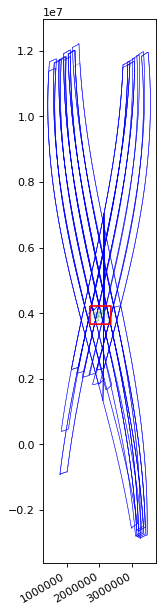

In [77]:
fig, ax = plt.subplots(figsize=(5,10),dpi=80)
fig.autofmt_xdate()

df = pd.read_csv('../Search_Discovery/Fiji_S1_SLC_ESA.csv')
df['repro'] = df['geometry'].apply(lambda x: reproject(str(x)))
df['repro'] = df['repro'].apply(wkt.loads)
gdf = geopandas.GeoDataFrame(df, geometry='repro', crs=('epsg:3460'))
gdf[gdf['sensoroperationalmode'].isin(['WV'])].plot(facecolor="none", edgecolor='b', alpha=0.5, lw=0.5, ax=ax);

aoigdf.plot(facecolor="none", edgecolor='r', lw=1.5, ax=ax);

# Use the borders again
borders.plot(facecolor="g", edgecolor='g', alpha=0.25, lw=1.5, ax=ax);

#ax.set_xlim(aoigdf.bounds.minx.values[0]-100000, aoigdf.bounds.maxx.values[0]+100000)
#ax.set_ylim(aoigdf.bounds.miny.values[0]-100000, aoigdf.bounds.maxy.values[0]+100000)

### **Data Characteristics:** Alaska Satellite Facility
What are the characteristics of available data covering the AoI from the preferred source?

***What is the distribution of acquisition frames across the AoI?***

We can joing together coordinates within the ASF query output and recreate the outlines of each scene.
- Where would be the most appropriate PoC site. **Ideally the full AoI bbox due to there not being too many 'frames'.**
- Can we use ASF-defined Frames as a UID for consistent geometries? **No!**
- Which scenes are Ascending vs Descending.
- Are there any 'bonus' S1 acquisition modes that could be folded into the project? **No, not covering the focus AoI.**

S1 Platform

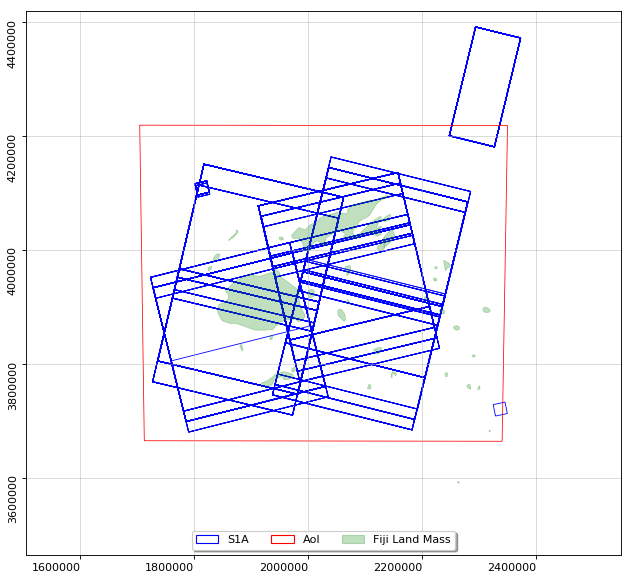

In [186]:
fig, ax = plt.subplots(figsize=(10,10),dpi=80)
fig.autofmt_xdate()

df = pd.read_csv('../Search_Discovery/Fiji_S1_SLC_ASF.csv')
#print(df.columns)
df['s1platform'] = df['Granule Name'].str[:3]
df['UnqFrame']= df['Frame Number'].astype(str) #df['Path Number'].astype(str) +"_"+ df['Frame Number'].astype(str)
df['Acquisition Date'] = pd.to_datetime(df['Acquisition Date'], format='%Y-%m-%d', utc=True)
#df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2020,1,1))]

# Convert lat lons of frame to polgyon & convert to gdf
df['ns'] = df[['Near Start Lon','Near Start Lat']].values.tolist()
df['fs'] = df[['Far Start Lon','Far Start Lat']].values.tolist()
df['ne'] = df[['Near End Lon','Near End Lat']].values.tolist()
df['fe'] = df[['Far End Lon','Far End Lat']].values.tolist()
df['coordinates'] = list(zip(df['ns'],df['fs'],df['fe'],df['ne'],df['ns']))
df['coordinates'] = df['coordinates'].apply(Polygon)
# create geodataframe
gdf = geopandas.GeoDataFrame(df, geometry='coordinates', crs=('epsg:4326'))
# Repro dataframe geometry
df['repro'] = df['coordinates'].apply(lambda x: reproject(str(x)))
# recreate geodataframe with reprojected coordinates
df['repro'] = df['repro'].apply(wkt.loads)
gdf = geopandas.GeoDataFrame(df, geometry='repro', crs=('epsg:3460'))

#gdf = gdf[gdf['s1platform'].isin([647])]
#print(len(np.unique(gdf['Frame Number'])))

# Define unique color labels
color_labels = gdf['s1platform'].unique()
def_cols = ['blue','green','red','yellow','purple']
#def_cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

# Plot from geodata frame and assign colors based on category
leg_patches = []
i = 0
for ctype, data in gdf.groupby('s1platform'):
    data.plot(edgecolor=def_cols[i],
              facecolor='none',
              ax = ax, 
              lw=0.75)
    # manually set legend entries due to geopandas version error
    leg_patches.append(mpatches.Patch(facecolor='none',edgecolor=def_cols[i], label=ctype))
    i+=1

# Plot AoI
aoigdf.plot(facecolor="none", edgecolor='r', lw=0.7, ax=ax);
leg_patches.append(mpatches.Patch(facecolor='none',edgecolor='red', label='AoI'))
# Use the borders again
borders.plot(facecolor="g", edgecolor='g', alpha=0.25, lw=0.7, ax=ax);
leg_patches.append(mpatches.Patch(facecolor='g',edgecolor='g', alpha=0.25, label='Fiji Land Mass'))

ax.legend(handles=leg_patches, loc='lower center', shadow=True, ncol=5);
ax.grid(alpha=0.5);
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);
ax.set_xlim(aoigdf.bounds.minx.values[0]-200000, aoigdf.bounds.maxx.values[0]+200000);
ax.set_ylim(aoigdf.bounds.miny.values[0]-200000, aoigdf.bounds.maxy.values[0]+200000);

S1 Orbit Direction

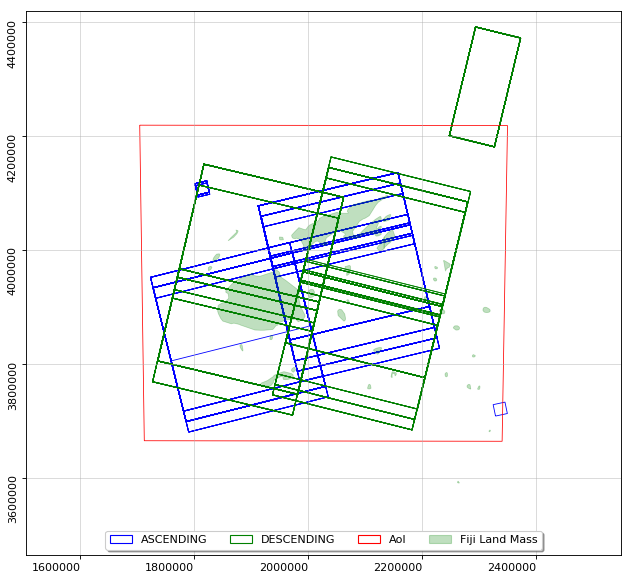

In [187]:
fig, ax = plt.subplots(figsize=(10,10),dpi=80)
fig.autofmt_xdate()

df = pd.read_csv('../Search_Discovery/Fiji_S1_SLC_ASF.csv')
#print(df.columns)
df['s1platform'] = df['Granule Name'].str[:3]
df['UnqFrame']= df['Frame Number'].astype(str) #df['Path Number'].astype(str) +"_"+ df['Frame Number'].astype(str)
df['Acquisition Date'] = pd.to_datetime(df['Acquisition Date'], format='%Y-%m-%d', utc=True)
#df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2020,1,1))]

# Convert lat lons of frame to polgyon & convert to gdf
df['ns'] = df[['Near Start Lon','Near Start Lat']].values.tolist()
df['fs'] = df[['Far Start Lon','Far Start Lat']].values.tolist()
df['ne'] = df[['Near End Lon','Near End Lat']].values.tolist()
df['fe'] = df[['Far End Lon','Far End Lat']].values.tolist()
df['coordinates'] = list(zip(df['ns'],df['fs'],df['fe'],df['ne'],df['ns']))
df['coordinates'] = df['coordinates'].apply(Polygon)
# create geodataframe
gdf = geopandas.GeoDataFrame(df, geometry='coordinates', crs=('epsg:4326'))
# Repro dataframe geometry
df['repro'] = df['coordinates'].apply(lambda x: reproject(str(x)))
# recreate geodataframe with reprojected coordinates
df['repro'] = df['repro'].apply(wkt.loads)
gdf = geopandas.GeoDataFrame(df, geometry='repro', crs=('epsg:3460'))

#gdf = gdf[gdf['s1platform'].isin([647])]
#print(len(np.unique(gdf['Frame Number'])))

# Define unique color labels
color_labels = gdf['Ascending or Descending?'].unique()
def_cols = ['blue','green','red','yellow','purple']
#def_cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

# Plot from geodata frame and assign colors based on category
leg_patches = []
i = 0
for ctype, data in gdf.groupby('Ascending or Descending?'):
    data.plot(edgecolor=def_cols[i],
              facecolor='none',
              ax = ax, 
              lw=0.75)
    # manually set legend entries due to geopandas version error
    leg_patches.append(mpatches.Patch(facecolor='none',edgecolor=def_cols[i], label=ctype))
    i+=1

# Plot AoI
aoigdf.plot(facecolor="none", edgecolor='r', lw=0.7, ax=ax);
leg_patches.append(mpatches.Patch(facecolor='none',edgecolor='red', label='AoI'))
# Use the borders again
borders.plot(facecolor="g", edgecolor='g', alpha=0.25, lw=0.7, ax=ax);
leg_patches.append(mpatches.Patch(facecolor='g',edgecolor='g', alpha=0.25, label='Fiji Land Mass'))

ax.legend(handles=leg_patches, loc='lower center', shadow=True, ncol=5);
ax.grid(alpha=0.5);
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);
ax.set_xlim(aoigdf.bounds.minx.values[0]-200000, aoigdf.bounds.maxx.values[0]+200000);
ax.set_ylim(aoigdf.bounds.miny.values[0]-200000, aoigdf.bounds.maxy.values[0]+200000);

S1 ASF-defined Frame Number (not a useful frame ID...)

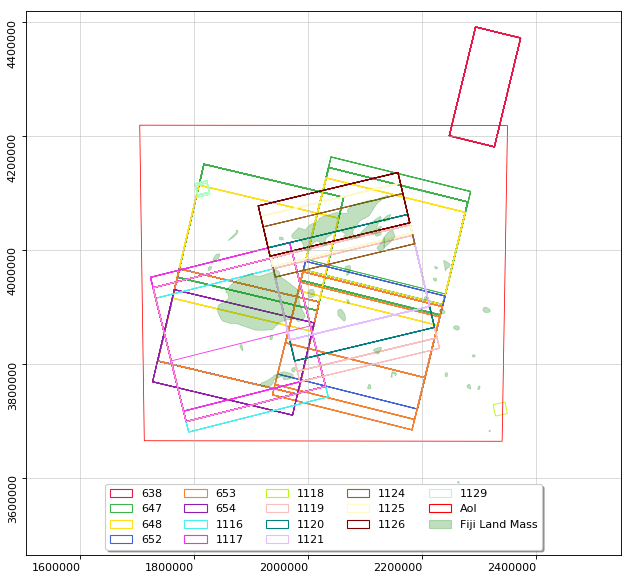

In [188]:
fig, ax = plt.subplots(figsize=(10,10),dpi=80)
fig.autofmt_xdate()

df = pd.read_csv('../Search_Discovery/Fiji_S1_SLC_ASF.csv')
#print(df.columns)
df['s1platform'] = df['Granule Name'].str[:3]
df['UnqFrame']= df['Frame Number'].astype(str) #df['Path Number'].astype(str) +"_"+ df['Frame Number'].astype(str)
df['Acquisition Date'] = pd.to_datetime(df['Acquisition Date'], format='%Y-%m-%d', utc=True)
#df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2020,1,1))]

# Convert lat lons of frame to polgyon & convert to gdf
df['ns'] = df[['Near Start Lon','Near Start Lat']].values.tolist()
df['fs'] = df[['Far Start Lon','Far Start Lat']].values.tolist()
df['ne'] = df[['Near End Lon','Near End Lat']].values.tolist()
df['fe'] = df[['Far End Lon','Far End Lat']].values.tolist()
df['coordinates'] = list(zip(df['ns'],df['fs'],df['fe'],df['ne'],df['ns']))
df['coordinates'] = df['coordinates'].apply(Polygon)
# create geodataframe
gdf = geopandas.GeoDataFrame(df, geometry='coordinates', crs=('epsg:4326'))
# Repro dataframe geometry
df['repro'] = df['coordinates'].apply(lambda x: reproject(str(x)))
# recreate geodataframe with reprojected coordinates
df['repro'] = df['repro'].apply(wkt.loads)
gdf = geopandas.GeoDataFrame(df, geometry='repro', crs=('epsg:3460'))

#gdf = gdf[gdf['s1platform'].isin([647])]
#print(len(np.unique(gdf['Frame Number'])))

# Define unique color labels
color_labels = gdf['Frame Number'].unique()
def_cols = ['blue','green','red','yellow','purple']
def_cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

# Plot from geodata frame and assign colors based on category
leg_patches = []
i = 0
for ctype, data in gdf.groupby('Frame Number'):
    data.plot(edgecolor=def_cols[i],
              facecolor='none',
              ax = ax, 
              lw=0.75)
    # manually set legend entries due to geopandas version error
    leg_patches.append(mpatches.Patch(facecolor='none',edgecolor=def_cols[i], label=ctype))
    i+=1

# Plot AoI
aoigdf.plot(facecolor="none", edgecolor='r', lw=0.7, ax=ax);
leg_patches.append(mpatches.Patch(facecolor='none',edgecolor='red', label='AoI'))
# Use the borders again
borders.plot(facecolor="g", edgecolor='g', alpha=0.25, lw=0.7, ax=ax);
leg_patches.append(mpatches.Patch(facecolor='g',edgecolor='g', alpha=0.25, label='Fiji Land Mass'))

ax.legend(handles=leg_patches, loc='lower center', shadow=True, ncol=5);
ax.grid(alpha=0.5);
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);
ax.set_xlim(aoigdf.bounds.minx.values[0]-200000, aoigdf.bounds.maxx.values[0]+200000);
ax.set_ylim(aoigdf.bounds.miny.values[0]-200000, aoigdf.bounds.maxy.values[0]+200000);

Sentinel-1 beam mode

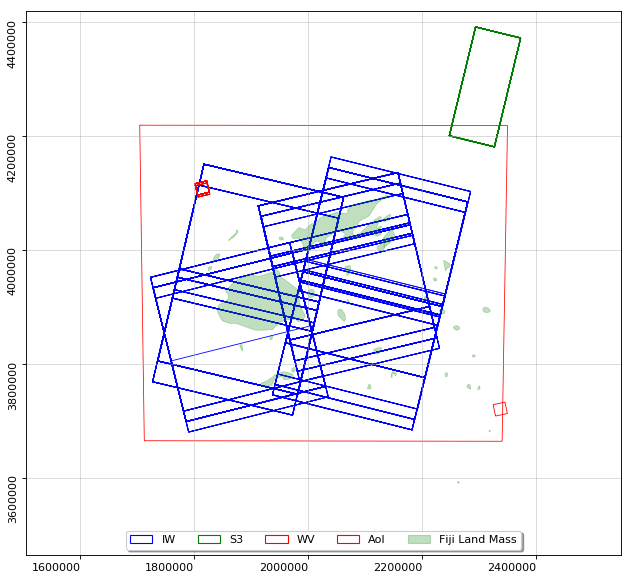

In [192]:
fig, ax = plt.subplots(figsize=(10,10),dpi=80)
fig.autofmt_xdate()

df = pd.read_csv('../Search_Discovery/Fiji_S1_SLC_ASF.csv')
#print(df.columns)
df['s1platform'] = df['Granule Name'].str[:3]
df['UnqFrame']= df['Frame Number'].astype(str) #df['Path Number'].astype(str) +"_"+ df['Frame Number'].astype(str)
df['Acquisition Date'] = pd.to_datetime(df['Acquisition Date'], format='%Y-%m-%d', utc=True)
#df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2020,1,1))]

# Convert lat lons of frame to polgyon & convert to gdf
df['ns'] = df[['Near Start Lon','Near Start Lat']].values.tolist()
df['fs'] = df[['Far Start Lon','Far Start Lat']].values.tolist()
df['ne'] = df[['Near End Lon','Near End Lat']].values.tolist()
df['fe'] = df[['Far End Lon','Far End Lat']].values.tolist()
df['coordinates'] = list(zip(df['ns'],df['fs'],df['fe'],df['ne'],df['ns']))
df['coordinates'] = df['coordinates'].apply(Polygon)
# create geodataframe
gdf = geopandas.GeoDataFrame(df, geometry='coordinates', crs=('epsg:4326'))
# Repro dataframe geometry
df['repro'] = df['coordinates'].apply(lambda x: reproject(str(x)))
# recreate geodataframe with reprojected coordinates
df['repro'] = df['repro'].apply(wkt.loads)
gdf = geopandas.GeoDataFrame(df, geometry='repro', crs=('epsg:3460'))

#gdf = gdf[gdf['s1platform'].isin([647])]
#print(len(np.unique(gdf['Frame Number'])))

# Define unique color labels
color_labels = gdf['Beam Mode'].unique()
def_cols = ['blue','green','red','yellow','purple']
#def_cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

# Plot from geodata frame and assign colors based on category
leg_patches = []
i = 0
for ctype, data in gdf.groupby('Beam Mode'):
    data.plot(edgecolor=def_cols[i],
              facecolor='none',
              ax = ax, 
              lw=0.75)
    # manually set legend entries due to geopandas version error
    leg_patches.append(mpatches.Patch(facecolor='none',edgecolor=def_cols[i], label=ctype))
    i+=1

# Plot AoI
aoigdf.plot(facecolor="none", edgecolor='r', lw=0.7, ax=ax);
leg_patches.append(mpatches.Patch(facecolor='none',edgecolor='red', label='AoI'))
# Use the borders again
borders.plot(facecolor="g", edgecolor='g', alpha=0.25, lw=0.7, ax=ax);
leg_patches.append(mpatches.Patch(facecolor='g',edgecolor='g', alpha=0.25, label='Fiji Land Mass'))

ax.legend(handles=leg_patches, loc='lower center', shadow=True, ncol=5);
ax.grid(alpha=0.5);
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);
ax.set_xlim(aoigdf.bounds.minx.values[0]-200000, aoigdf.bounds.maxx.values[0]+200000);
ax.set_ylim(aoigdf.bounds.miny.values[0]-200000, aoigdf.bounds.maxy.values[0]+200000);

Unique tracks (paths) within IW mode only. Other modes not considered as likely not to be used within project.

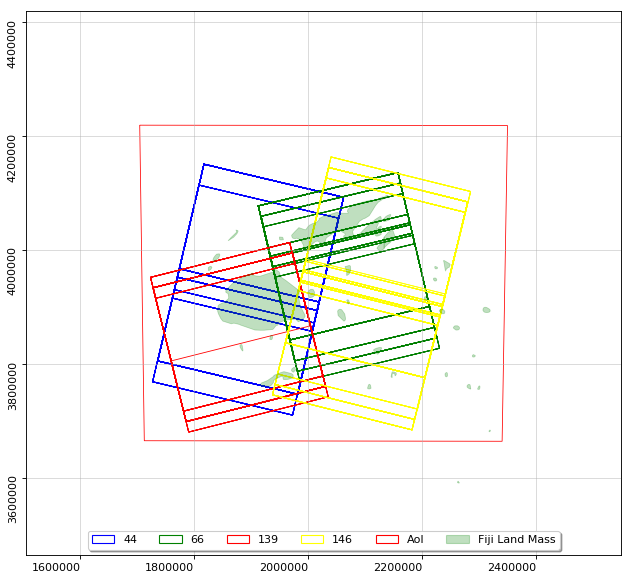

In [197]:
fig, ax = plt.subplots(figsize=(10,10),dpi=80)
fig.autofmt_xdate()

df = pd.read_csv('../Search_Discovery/Fiji_S1_SLC_ASF.csv')
#print(df.columns)
df['s1platform'] = df['Granule Name'].str[:3]
df['UnqFrame']= df['Frame Number'].astype(str) #df['Path Number'].astype(str) +"_"+ df['Frame Number'].astype(str)
df['Acquisition Date'] = pd.to_datetime(df['Acquisition Date'], format='%Y-%m-%d', utc=True)
#df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2020,1,1))]

# Convert lat lons of frame to polgyon & convert to gdf
df['ns'] = df[['Near Start Lon','Near Start Lat']].values.tolist()
df['fs'] = df[['Far Start Lon','Far Start Lat']].values.tolist()
df['ne'] = df[['Near End Lon','Near End Lat']].values.tolist()
df['fe'] = df[['Far End Lon','Far End Lat']].values.tolist()
df['coordinates'] = list(zip(df['ns'],df['fs'],df['fe'],df['ne'],df['ns']))
df['coordinates'] = df['coordinates'].apply(Polygon)
# create geodataframe
gdf = geopandas.GeoDataFrame(df, geometry='coordinates', crs=('epsg:4326'))
# Repro dataframe geometry
df['repro'] = df['coordinates'].apply(lambda x: reproject(str(x)))
# recreate geodataframe with reprojected coordinates
df['repro'] = df['repro'].apply(wkt.loads)
gdf = geopandas.GeoDataFrame(df, geometry='repro', crs=('epsg:3460'))

gdf = gdf[gdf['Beam Mode'].isin(['IW'])]
#print(len(np.unique(gdf['Frame Number'])))

# Define unique color labels
color_labels = gdf['Path Number'].unique()
def_cols = ['blue','green','red','yellow','purple']
#def_cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

# Plot from geodata frame and assign colors based on category
leg_patches = []
i = 0
for ctype, data in gdf.groupby('Path Number'):
    data.plot(edgecolor=def_cols[i],
              facecolor='none',
              ax = ax, 
              lw=0.75)
    # manually set legend entries due to geopandas version error
    leg_patches.append(mpatches.Patch(facecolor='none',edgecolor=def_cols[i], label=ctype))
    i+=1

# Plot AoI
aoigdf.plot(facecolor="none", edgecolor='r', lw=0.7, ax=ax);
leg_patches.append(mpatches.Patch(facecolor='none',edgecolor='red', label='AoI'))
# Use the borders again
borders.plot(facecolor="g", edgecolor='g', alpha=0.25, lw=0.7, ax=ax);
leg_patches.append(mpatches.Patch(facecolor='g',edgecolor='g', alpha=0.25, label='Fiji Land Mass'))

ax.legend(handles=leg_patches, loc='lower center', shadow=True, ncol=6);
ax.grid(alpha=0.5);
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);
ax.set_xlim(aoigdf.bounds.minx.values[0]-200000, aoigdf.bounds.maxx.values[0]+200000);
ax.set_ylim(aoigdf.bounds.miny.values[0]-200000, aoigdf.bounds.maxy.values[0]+200000);

***How frequently is each frame imaged?***


The frequency of acquistions across each track... Again just IW mode...

{'ASCENDING': 'red', 'DESCENDING': 'green'}


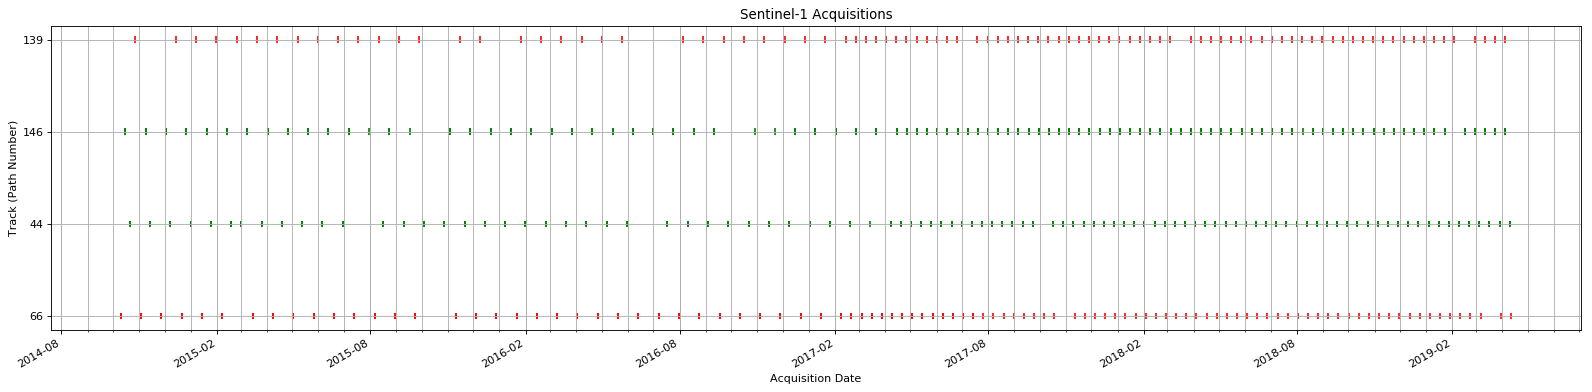

In [380]:
fig, ax = plt.subplots(figsize=(20,5),dpi=80)
fig.autofmt_xdate()

df = pd.read_csv('../Search_Discovery/Fiji_S1_SLC_ASF.csv')
#df['s1platform'] = df['identifier'].str[:3]
df['UnqFrame']= df['Frame Number'].astype(str) #df['Path Number'].astype(str) +"_"+ df['Frame Number'].astype(str)
df['Acquisition Date'] = pd.to_datetime(df['Acquisition Date'], format='%Y-%m-%d', utc=True)

df = df[df['Beam Mode'].isin(['IW'])]

# Unique category labels: 'D', 'F', 'G', ...
color_labels = df['Ascending or Descending?'].unique()
def_cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
def_cols = ['red','green','blue','yellow','purple']
color_map = dict(zip(color_labels, def_cols[:len(color_labels)]))

print ( color_map )

ax.scatter(df['Acquisition Date'].values, df['Path Number'].values.astype(str), marker='|', color=df['Ascending or Descending?'].map(color_map));

ax.set_ylabel('Track (Path Number)');
ax.set_xlabel("Acquisition Date");
#ax.legend(['USGS_L8','USGS_L7','USGS_L4-5TM','USGS_L1-4MSS']);
ax.set_title('Sentinel-1 Acquisitions');
ax.xaxis.set_major_locator(mdates.AutoDateLocator());
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m") ); 
ax.xaxis.set_minor_locator(mdates.MonthLocator());
#ax.xaxis.set_minor_formatter(DateFormatter("%m") ); 
ax.grid(which='both')
fig.tight_layout()
fig.savefig('../Search_Discovery/Fiji_S1_tempdistribution_platform');

***Are acquistions consistently single or dual polarisation?***

Single vs dual pol may be a requirement of value added products. 

The coverage of each track by single and dual polarisation.

{'VV': 'green', 'VV VH': 'red'}


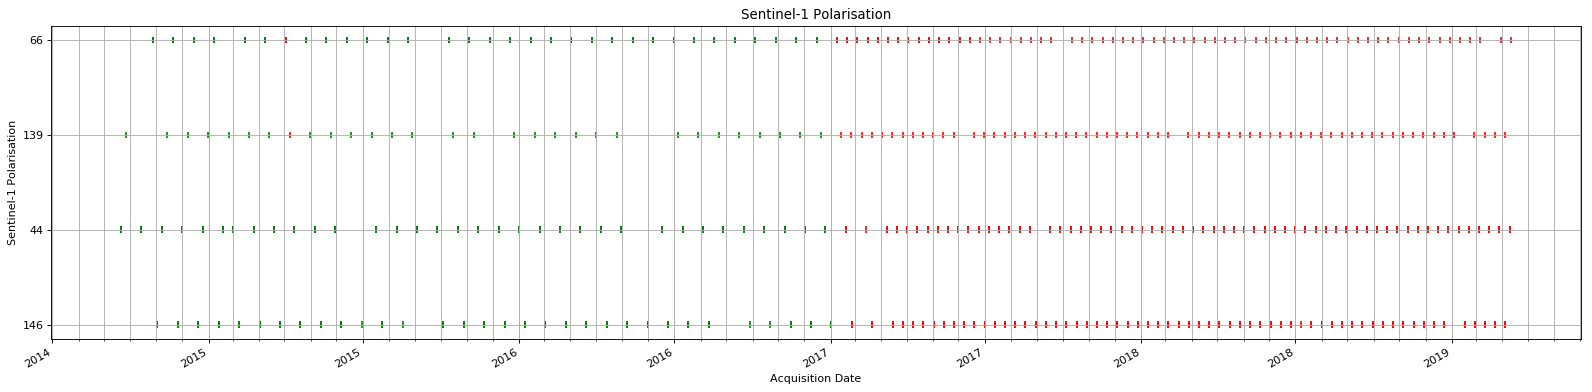

In [381]:
fig, ax = plt.subplots(figsize=(20,5),dpi=80)
fig.autofmt_xdate()

df = pd.read_csv('../Search_Discovery/Fiji_S1_SLC_ESA.csv')
df['s1platform'] = df['identifier'].str[:3]
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)

df = df[df['sensoroperationalmode'].isin(['IW'])]

# Unique category labels: 'D', 'F', 'G', ...
color_labels = df['polarisationmode'].unique()
def_cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
def_cols = ['red','green','blue','yellow','purple']
color_map = dict(zip(color_labels, def_cols[:len(color_labels)]))
print ( color_map )

ax.scatter(df['Acquisition Date'].values, df['relativeorbitnumber'].values.astype(str), marker='|', color=df['polarisationmode'].map(color_map));

ax.set_ylabel("Sentinel-1 Polarisation");
ax.set_xlabel("Acquisition Date");
#ax.legend(['USGS_L8','USGS_L7','USGS_L4-5TM','USGS_L1-4MSS']);
ax.set_title('Sentinel-1 Polarisation');
ax.xaxis.set_major_locator(mdates.AutoDateLocator());
ax.xaxis.set_major_formatter(DateFormatter("%Y") ); 
ax.xaxis.set_minor_locator(mdates.MonthLocator());
#ax.xaxis.set_minor_formatter(DateFormatter("%m") ); 
ax.grid(which='both')
fig.tight_layout()
fig.savefig('../Search_Discovery/Fiji_S1_tempdistribution_polarisation');

***include time of date analysis*** (important for high and low tide mapping, consistent change analysis, etc.

**The 'nitty gritty' of data volumes and potential storage requirements.**

Total No. Scenes:  620

 No. Scenes per Track 
 {'ASCENDING': 'purple', 'DESCENDING': 'green'}


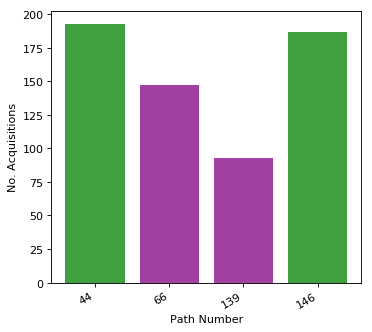

In [360]:
fig, ax = plt.subplots(figsize=(5,5),dpi=80)
fig.autofmt_xdate()

df = pd.read_csv('../Search_Discovery/Fiji_S1_SLC_ASF.csv')
df['s1platform'] = df['Granule Name'].str[:3]
df['UnqFrame']= df['Frame Number'].astype(str) #df['Path Number'].astype(str) +"_"+ df['Frame Number'].astype(str)
df['Acquisition Date'] = pd.to_datetime(df['Acquisition Date'], format='%Y-%m-%d', utc=True)

df = df[df['Beam Mode'].isin(['IW'])]

#df = df[(df['Acquisition Date']>datetime.date(2018,1,1)) & (df['Acquisition Date']<datetime.date(2019,1,1))]

print ( 'Total No. Scenes: ', df.shape[0] )

color_labels = df['Ascending or Descending?'].unique()
color_labels = [ df[df['Path Number'].isin([str(i)])]['Ascending or Descending?'].unique()[0] for i in df['Path Number'].value_counts().index.values ]
def_cols = ['red','green','blue','purple','yellow']
color_map = dict(zip(color_labels, def_cols[:len(color_labels)]))
print ( '\n', 'No. Scenes per Track', '\n', color_map )

leg_patches = []
i = 0
for ctype, data in df.groupby('Path Number'):
        
    ax.bar(str(ctype),data.shape[0],
          facecolor=color_map[data['Ascending or Descending?'].unique()[0]],
          alpha=0.75)
    
    i+=1

ax.set_xlabel('Path Number');
ax.set_ylabel('No. Acquisitions');


Total Volume (~GB):  2049.7097206287385

 Total Volume per Track 
 {'ASCENDING': 'purple', 'DESCENDING': 'green'}


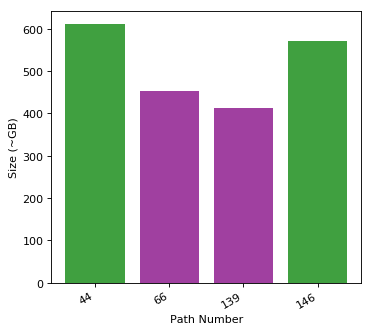

In [372]:
fig, ax = plt.subplots(figsize=(5,5),dpi=80)
fig.autofmt_xdate()

df = pd.read_csv('../Search_Discovery/Fiji_S1_SLC_ASF.csv')
df['s1platform'] = df['Granule Name'].str[:3]
df['UnqFrame']= df['Frame Number'].astype(str) #df['Path Number'].astype(str) +"_"+ df['Frame Number'].astype(str)
df['Acquisition Date'] = pd.to_datetime(df['Acquisition Date'], format='%Y-%m-%d', utc=True)

df = df[df['Beam Mode'].isin(['IW'])]

#df = df[(df['Acquisition Date']>datetime.date(2018,1,1)) & (df['Acquisition Date']<datetime.date(2019,1,1))]

print ( 'Total Volume (~GB): ', df['Size (MB)'].sum()/1000 )


color_labels = df['Ascending or Descending?'].unique()
color_labels = [ df[df['Path Number'].isin([str(i)])]['Ascending or Descending?'].unique()[0] for i in df['Path Number'].value_counts().index.values ]
def_cols = ['red','green','blue','purple','yellow']
color_map = dict(zip(color_labels, def_cols[:len(color_labels)]))

print ( '\n', 'Total Volume per Track', '\n', color_map )

leg_patches = []
i = 0
for ctype, data in df.groupby('Path Number'):
        
    ax.bar(str(ctype),data['Size (MB)'].sum()/1000,
          facecolor=color_map[data['Ascending or Descending?'].unique()[0]],
          alpha=0.75)
    
    i+=1

ax.set_xlabel('Path Number');
ax.set_ylabel('Size (~GB)');


Average File Size (~GB):  3.305983420368933 +/ 1.2523433978130938

 Average File Size per Track 
 {'ASCENDING': 'purple', 'DESCENDING': 'green'}


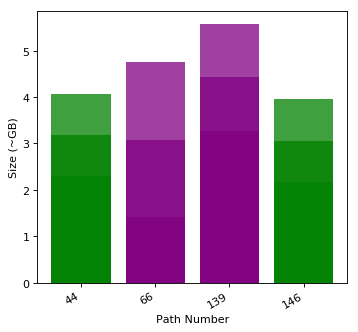

In [374]:
fig, ax = plt.subplots(figsize=(5,5),dpi=80)
fig.autofmt_xdate()

df = pd.read_csv('../Search_Discovery/Fiji_S1_SLC_ASF.csv')
df['s1platform'] = df['Granule Name'].str[:3]
df['UnqFrame']= df['Frame Number'].astype(str) #df['Path Number'].astype(str) +"_"+ df['Frame Number'].astype(str)
df['Acquisition Date'] = pd.to_datetime(df['Acquisition Date'], format='%Y-%m-%d', utc=True)

df = df[df['Beam Mode'].isin(['IW'])]

#df = df[(df['Acquisition Date']>datetime.date(2018,1,1)) & (df['Acquisition Date']<datetime.date(2019,1,1))]

print ( 'Average File Size (~GB): ', df['Size (MB)'].mean()/1000, '+/',  df['Size (MB)'].std()/1000)


color_labels = df['Ascending or Descending?'].unique()
color_labels = [ df[df['Path Number'].isin([str(i)])]['Ascending or Descending?'].unique()[0] for i in df['Path Number'].value_counts().index.values ]
def_cols = ['red','green','blue','purple','yellow']
color_map = dict(zip(color_labels, def_cols[:len(color_labels)]))

print ( '\n', 'Average File Size per Track', '\n', color_map )

leg_patches = []
i = 0
for ctype, data in df.groupby('Path Number'):
        
    ax.bar(str(ctype),data['Size (MB)'].mean()/1000,
          facecolor=color_map[data['Ascending or Descending?'].unique()[0]],
          alpha=0.75)
    
    ax.bar(str(ctype),data['Size (MB)'].mean()/1000-data['Size (MB)'].std()/1000,
          facecolor=color_map[data['Ascending or Descending?'].unique()[0]],
          alpha=0.75)
    
    ax.bar(str(ctype),data['Size (MB)'].mean()/1000+data['Size (MB)'].std()/1000,
          facecolor=color_map[data['Ascending or Descending?'].unique()[0]],
          alpha=0.75)
    
    i+=1

ax.set_xlabel('Path Number');
ax.set_ylabel('Size (~GB)');


**Conclusions**
- ASF can be considered reliable source of S1 products but only when considering SLC.
- Only difference in SLC no. is within last couple months, which ESA is likely to be still correcting.

### **PoC 'ARD' Processing:** SNAP

**Why SNAP**
- Open source
- ESA choice

**'Ideal' Processing Stages**
- CEOS definition

**Actual Processing Stages**
- xml graph

**Additional products**
- 'Classification' bands undefined within ODC community. We generate those we believe most appropriate. 

**Automated Processing**
- actual processing for PoC

**File Sizes and Storage Implications**
- Est. relative file sizes from SLC to ARD products.

# Sentinel-2

### **Query:** GoogleCloud, ESA Open Access Hub(, Sedas tbc)

In [382]:
# Query ESA Open Access Hub using sentinelsat tool.
esa_api = SentinelAPI('tmj21','Welcome12!')
res = esa_api.query(wkt_aoi,platformname='Sentinel-2',producttype='S2MSI1C')
esa_api.to_geodataframe(res).to_csv('../Search_Discovery/Fiji_S2_L1C_ESA.csv')
res = esa_api.query(wkt_aoi,platformname='Sentinel-2',producttype='S2MSI2A')
esa_api.to_geodataframe(res).to_csv('../Search_Discovery/Fiji_S2_L2A_ESA.csv')

Querying products: 100%|██████████| 2029/2029 [00:13<00:00, 145.14 products/s]


In [441]:
# Query GCloud - No need to download s2 granule shapefile as geometry exists within df from esa api query. Simply look up corresponding granules.
# lookup unique granules
df = pd.read_csv('../Search_Discovery/Fiji_S2_L1C_ESA.csv')
search_grans = list(df.identifier.str[38:44].unique())
search_grans = [ i[1:] for i in search_grans ] # drop the T

# download latest gcloud csv - takes a minute or two (this is metadata for the entire S2 archive...)
gcloudcsv = '../Search_Discovery/entireS2GCloud.csv.gz'
if not os.path.exists(gcloudcsv):
    csv_url = "https://storage.googleapis.com/gcp-public-data-sentinel-2/index.csv.gz"
    urllib.request.urlretrieve(csv_url, gcloudcsv)

# subset to corresponding granules and write new file
df = pd.read_csv(gcloudcsv)
df = df[ df.MGRS_TILE.isin(search_grans) ]
df.to_csv('../Search_Discovery/Fiji_S2_L1C_GCL.csv')

### **Determining a suitable data source:** Google Cloud, ESA Open Access Hub(, Sedas, USGS tbc)

***Are there consistent data volumes across data sources and processing levels?***
- Can we be confident in routinely accessing L2A products from SciHub in an operational scenario beyond the project timeframes?
- Can we be confident in accessing L1C products from GoogleCLoud for the purpose of processing the full archive?

Determining monthly data volumes across each source for each product gives a fair representation of how consistent the 'mirror' sites re-distribute the products to be used within the project. 

Findings
- A reasonably consistent L1C archive is found at Google CLoud as far back as Spetember 2016 (with slight variations for **TBD** reasons).
- ESA SciHub L2A rolling archive seems to exactly mirror L1C.

Recommendations
- GoogleCloud looks to be a robust source for **archive** S2 L1C products from approx. September 2016 to present. Perhaps a different source should be used before this date (slower SciHub?).
- Pulling L2A products from ESA will **remove the requirement for S2 ARD processing within the operational DC** scenario. **Processing of the S2 archive from L1C should therefore be undertaken using a consistent correction algorithm to that being used by ESA; Sen2Cor or Maja**.

Further questions
- What is the cause of the variations?
- Are the granules precisely consistent?


No. GCloud prods before removing products of NaN size 12789
No. GCloud prods after  removing products of NaN size 12518


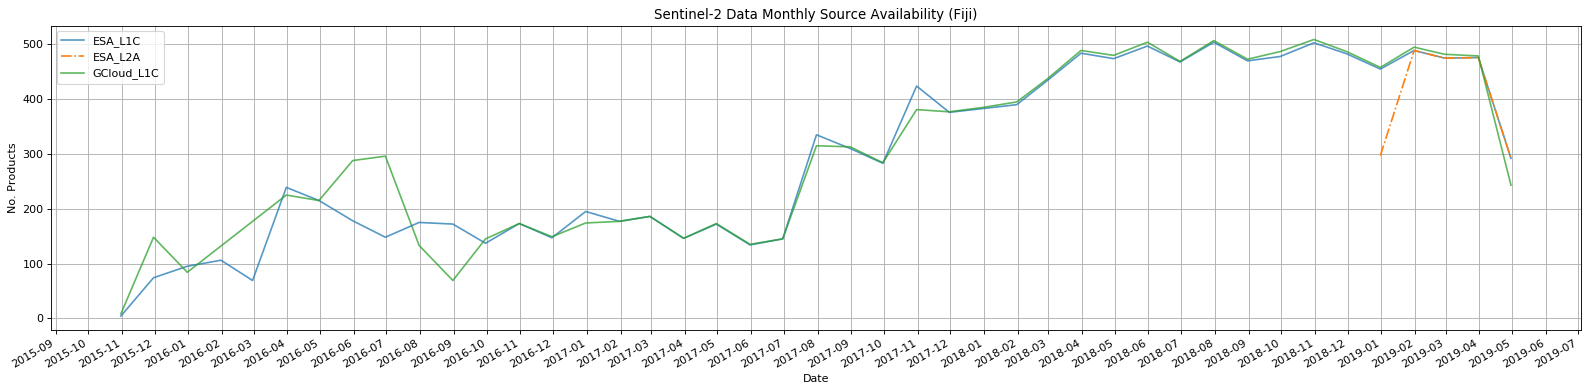

In [669]:
# Create monthly data availability plot from each data source.
fig, ax = plt.subplots(figsize=(20,5),dpi=80)
fig.autofmt_xdate()

df = pd.read_csv('../Search_Discovery/Fiji_S2_L1C_ESA.csv')
#print('ESA GRD \n', 'No. Prods: ', len(df))
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%dT%H:%M:%S', utc=True)
# Convert dates into datetime objects
df['Acquisition Date'] = pd.to_datetime(df['Acquisition Date'], format='%Y-%m-%dT%H:%M:%S', utc=True)
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values, alpha=0.75);

df = pd.read_csv('../Search_Discovery/Fiji_S2_L2A_ESA.csv')
#print('ESA SLC \n', 'No. Prods: ', len(df))
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%dT%H:%M:%S', utc=True)
# Convert dates into datetime objects
df['Acquisition Date'] = pd.to_datetime(df['Acquisition Date'], format='%Y-%m-%dT%H:%M:%S', utc=True)
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values, ls='dashdot');

df = pd.read_csv('../Search_Discovery/Fiji_S2_L1C_GCL.csv')
#print('ASF GRD \n', 'No. Prods: ', len(df), 'Vol Prods (TB): ', df['Size (MB)'].sum()/1000000)
# Convert dates into datetime objects
df['Acquisition Date'] = pd.to_datetime(df['SENSING_TIME'], format='%Y-%m-%dT%H:%M:%S', utc=True)
print ('No. GCloud prods before removing products of NaN size', df.shape[0] )
df = df.dropna(subset=['TOTAL_SIZE'])
print ('No. GCloud prods after  removing products of NaN size', df.shape[0] )

df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values, alpha = 0.75);

#'bD-.'
ax.set_ylabel("No. Products");
ax.set_xlabel("Date");
#ax.set_ylim(0,40)
ax.legend(['ESA_L1C','ESA_L2A','GCloud_L1C','ASF_SLC'], loc='upper left');
#ax.legend.loc('upper left')
ax.set_title('Sentinel-2 Data Monthly Source Availability (Fiji)');
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m") ) 
ax.grid();
fig.tight_layout();
#fig.savefig('../Search_Discovery/Fiji_S1_Monthly_Source_Availability');

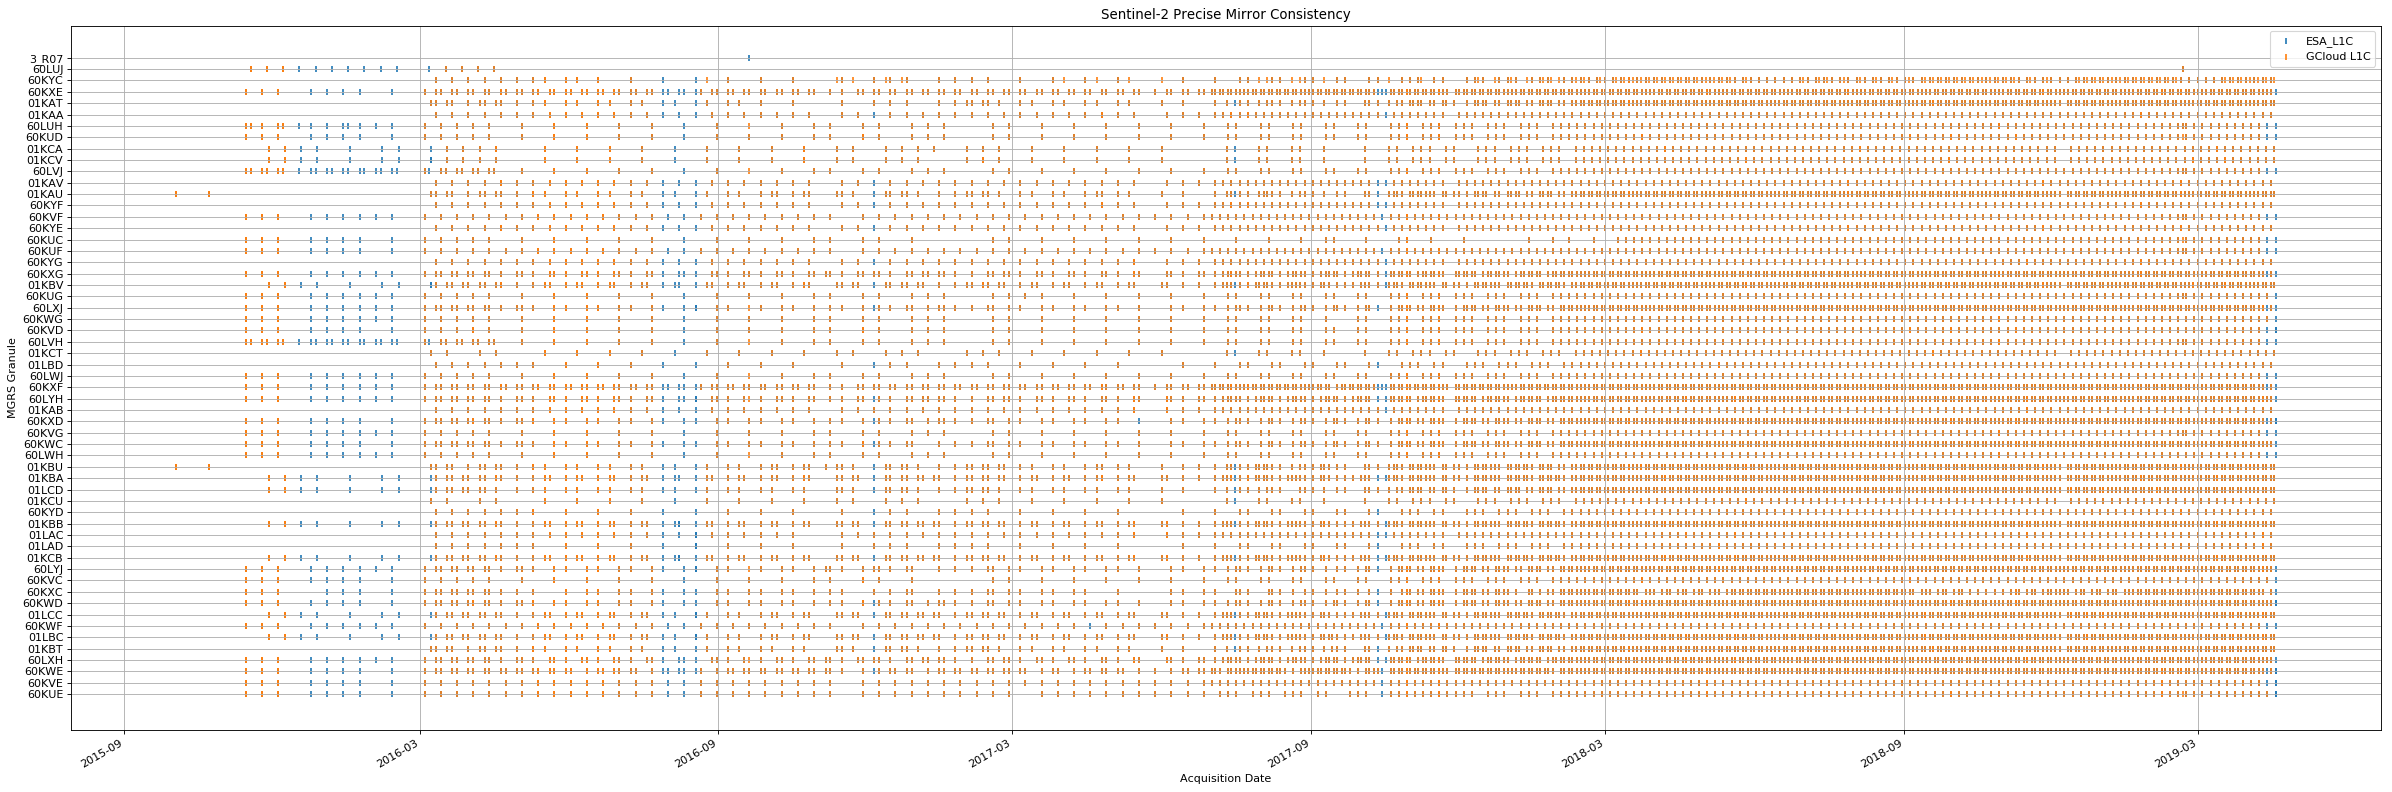

In [680]:
fig, ax = plt.subplots(figsize=(30,10),dpi=80)
fig.autofmt_xdate()

df = pd.read_csv('../Search_Discovery/Fiji_S2_L1C_ESA.csv')
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)
df['granules'] = df.identifier.str[39:44]
#df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2020,1,1))]
ax.scatter(df['Acquisition Date'].values, df['granules'].values, marker='|');

df = pd.read_csv('../Search_Discovery/Fiji_S2_L1C_GCL.csv')
df['Acquisition Date'] = pd.to_datetime(df['SENSING_TIME'], format='%Y-%m-%d', utc=True)
df['granules'] = df['MGRS_TILE']
# remove files showing as NaN size
df = df.dropna(subset=['TOTAL_SIZE'])
#df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2020,1,1))]
ax.scatter(df['Acquisition Date'].values, df['granules'].values, marker='|');

ax.set_ylabel('MGRS Granule');
ax.set_xlabel("Acquisition Date");
ax.legend(['ESA_L1C','GCloud L1C','USGS_L4-5TM','USGS_L1-4MSS']);
ax.set_title("Sentinel-2 Precise Mirror Consistency");
ax.xaxis.set_major_locator(mdates.AutoDateLocator());
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m") ); 
ax.grid(which='both')
fig.tight_layout()
#fig.savefig('../Search_Discovery/Fiji_S1_tempdistribution_orbitdirection');

In [18]:
df = pd.read_csv('../Search_Discovery/Fiji_S2_L1C_ESA.csv')
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)
df['granules'] = df.identifier.str[39:44]
#df['time'] = df.beginposition.dt.time
#df.time.values[:5]
np.unique(df['Acquisition Date'].dt.hour.values)

array([22])

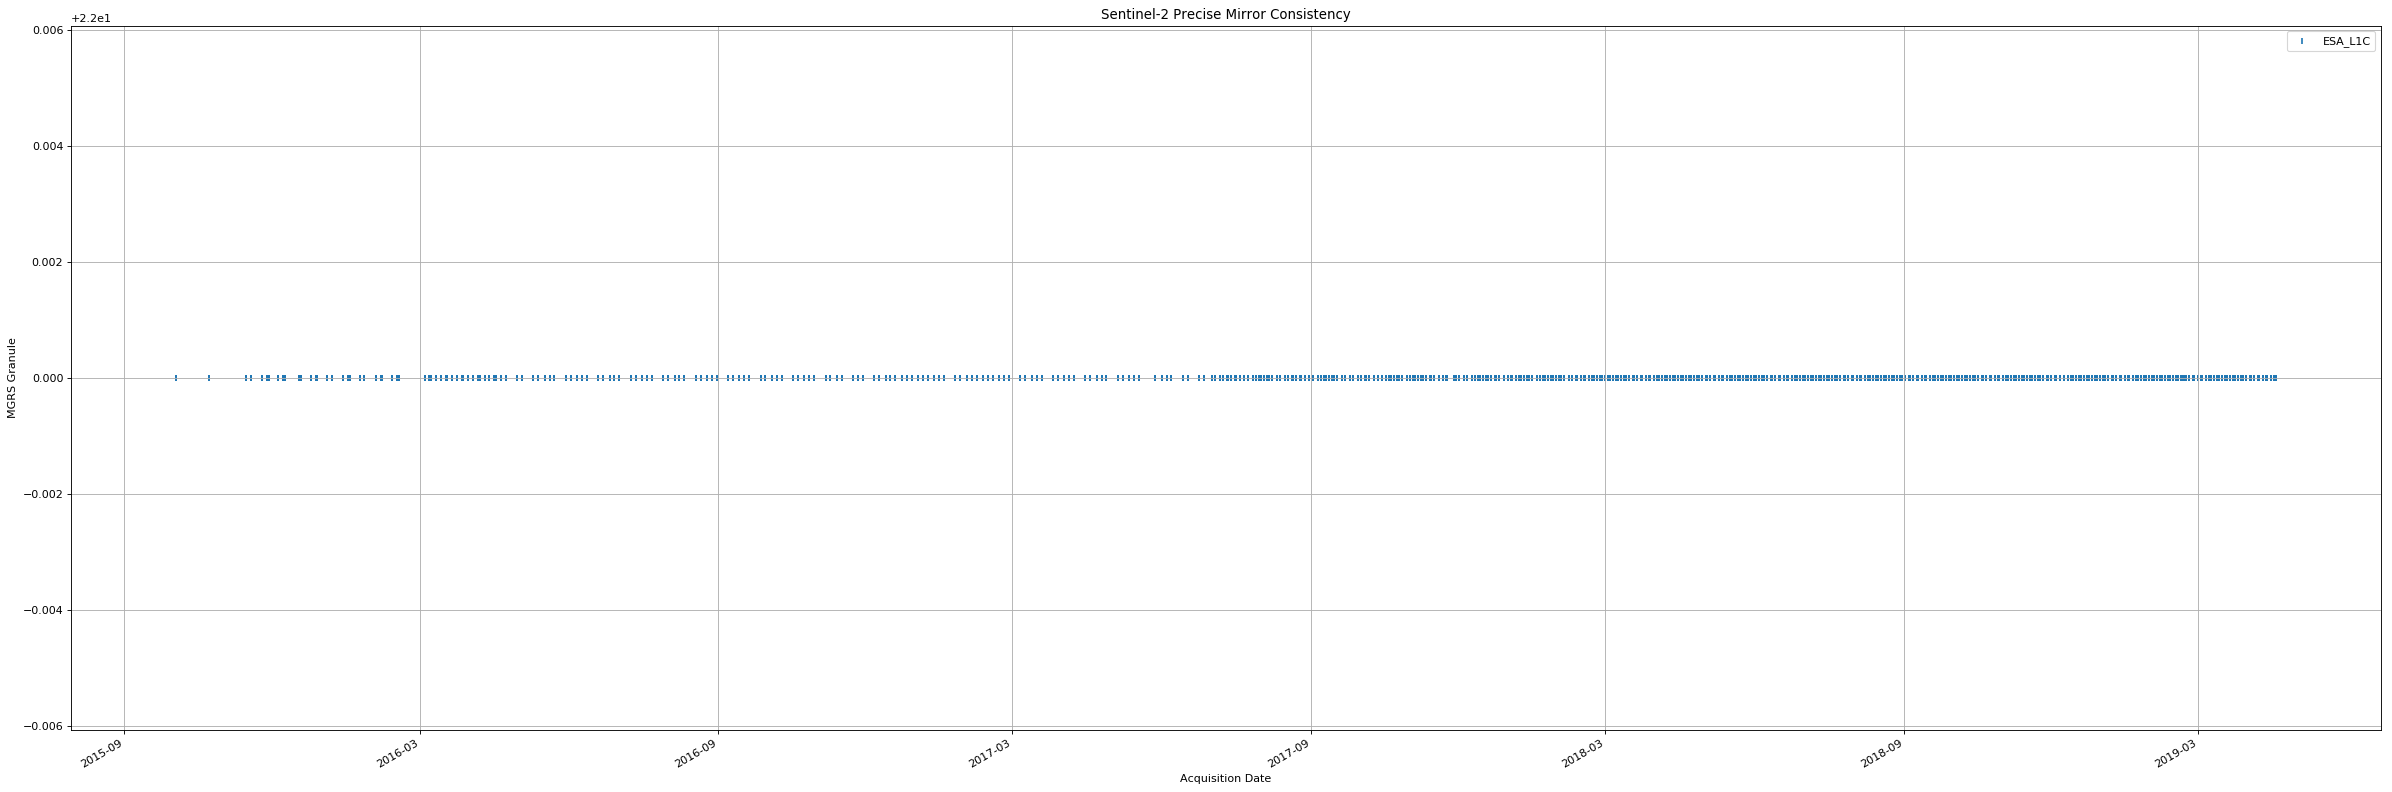

In [16]:
fig, ax = plt.subplots(figsize=(30,10),dpi=80)
fig.autofmt_xdate()

df = pd.read_csv('../Search_Discovery/Fiji_S2_L1C_ESA.csv')
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)
df['granules'] = df.identifier.str[39:44]
#df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2020,1,1))]
ax.scatter(df['Acquisition Date'].values, df['Acquisition Date'].dt.hour, marker='|');

ax.set_ylabel('MGRS Granule');
ax.set_xlabel("Acquisition Date");
ax.legend(['ESA_L1C','GCloud L1C','USGS_L4-5TM','USGS_L1-4MSS']);
ax.set_title("Sentinel-2 Precise Mirror Consistency");
ax.xaxis.set_major_locator(mdates.AutoDateLocator());
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m") ); 
ax.grid(which='both')
fig.tight_layout()
#fig.savefig('../Search_Discovery/Fiji_S1_tempdistribution_orbitdirection');

***include time of date analysis*** (important for high and low tide mapping, consistent change analysis, etc.

### **Data Characteristics:** ESA SciHub used as truth
What are the characteristics of available data covering the AoI from the preferred source?

**How consistent are acquisition footprints?**

Spatial distribution of granule coverage over AoI

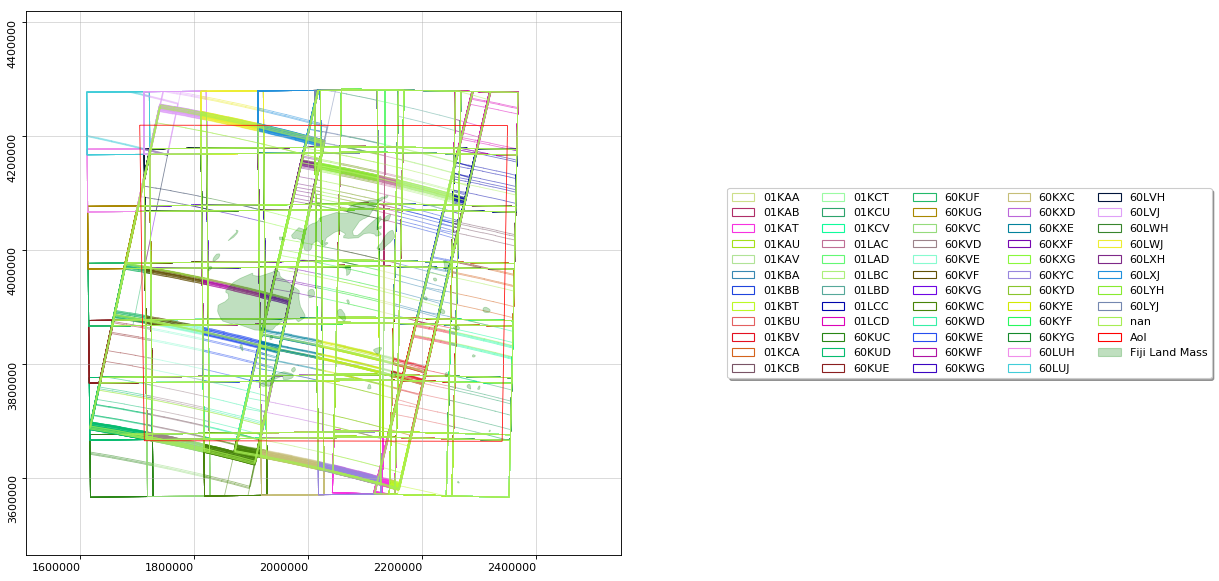

In [504]:
import random

fig, ax = plt.subplots(figsize=(10,10),dpi=80)
fig.autofmt_xdate()

df = pd.read_csv('../Search_Discovery/Fiji_S2_L1C_ESA.csv')
#print(df.columns)
df['s1platform'] = df['identifier'].str[:3]
df['UnqFrame']= df['tileid'].astype(str) #df['Path Number'].astype(str) +"_"+ df['Frame Number'].astype(str)
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)

#df = df[(df['Acquisition Date']>datetime.date(2019,3,1)) & (df['Acquisition Date']<datetime.date(2020,1,1))]

df['coordinates'] = df['geometry'].apply(wkt.loads)
# create geodataframe
gdf = geopandas.GeoDataFrame(df, geometry='coordinates', crs=('epsg:4326'))
# Repro dataframe geometry
df['repro'] = df['coordinates'].apply(lambda x: reproject(str(x)))
# recreate geodataframe with reprojected coordinates
df['repro'] = df['repro'].apply(wkt.loads)
gdf = geopandas.GeoDataFrame(df, geometry='repro', crs=('epsg:3460'))

#gdf = gdf[gdf['s1platform'].isin([647])]
#print(len(np.unique(gdf['Frame Number'])))

# Define unique color labels
color_labels = gdf['UnqFrame'].unique()
def_cols = ['blue','green','red','yellow','purple']
def_cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000', ]
def_cols = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(color_labels))]

# Plot from geodata frame and assign colors based on category
leg_patches = []
i = 0
for ctype, data in gdf.groupby('UnqFrame'):
    data.plot(edgecolor=def_cols[i],
              facecolor='none',
              ax = ax, 
              lw=0.75,
              alpha=0.5)
    # manually set legend entries due to geopandas version error
    leg_patches.append(mpatches.Patch(facecolor='none',edgecolor=def_cols[i], label=ctype))
    i+=1

# Plot AoI
aoigdf.plot(facecolor="none", edgecolor='r', lw=0.7, ax=ax);
leg_patches.append(mpatches.Patch(facecolor='none',edgecolor='red', label='AoI'))
# Use the borders again
borders.plot(facecolor="g", edgecolor='g', alpha=0.25, lw=0.7, ax=ax);
leg_patches.append(mpatches.Patch(facecolor='g',edgecolor='g', alpha=0.25, label='Fiji Land Mass'))

ax.legend(handles=leg_patches, loc='center right', bbox_to_anchor=(2, 0.5), shadow=True, ncol=5);
ax.grid(alpha=0.5);
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);
ax.set_xlim(aoigdf.bounds.minx.values[0]-200000, aoigdf.bounds.maxx.values[0]+200000);
ax.set_ylim(aoigdf.bounds.miny.values[0]-200000, aoigdf.bounds.maxy.values[0]+200000);

**What was the impact of S2B coming online?**

Temporal distribution of acquisitions across each granule.

{'S2A': 'red', 'S2B': 'green'}


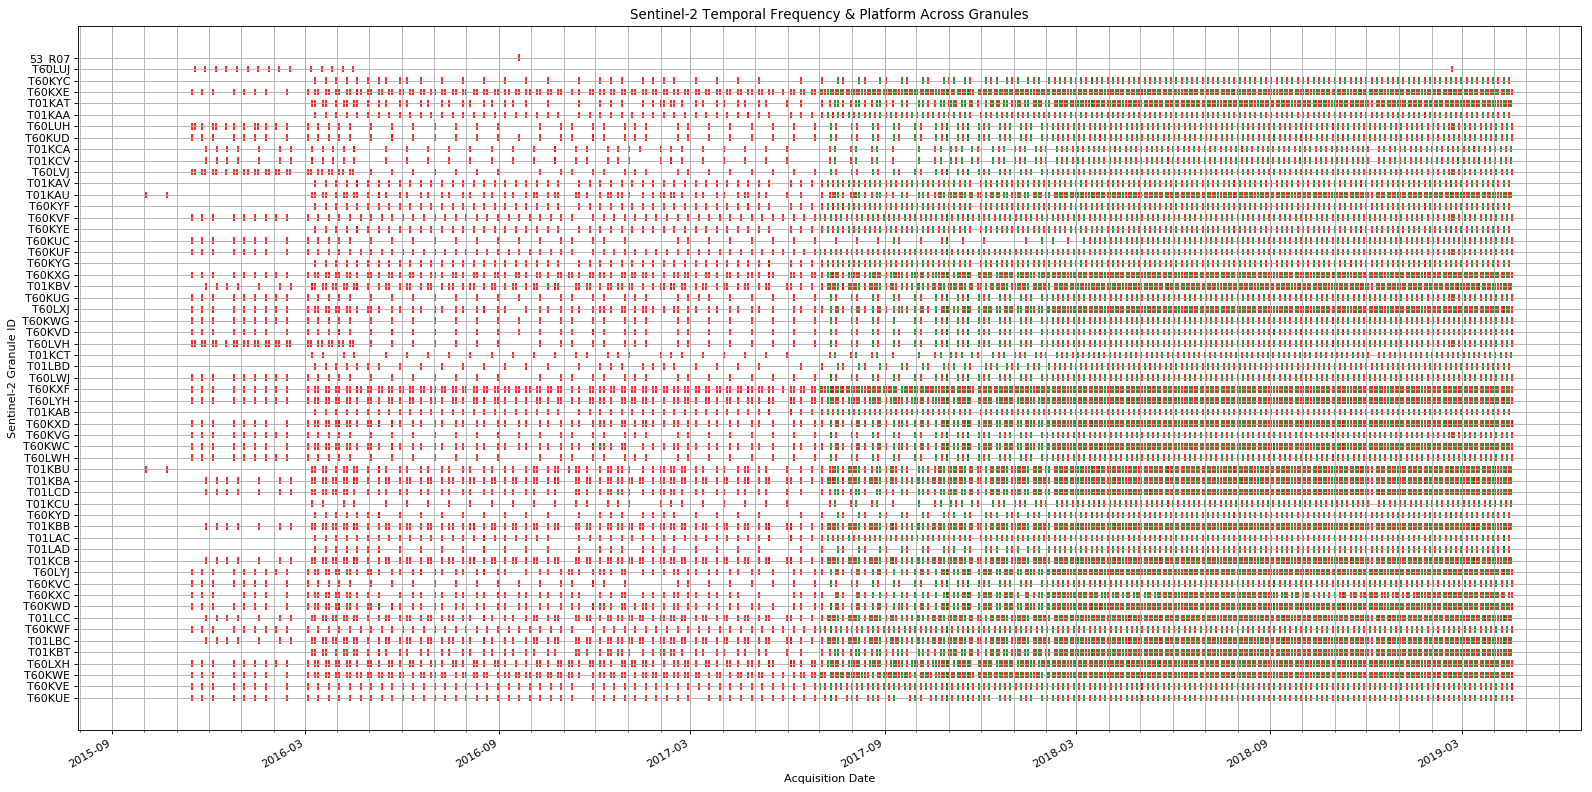

In [604]:
import matplotlib.colors as c

fig, ax = plt.subplots(figsize=(20,10),dpi=80)
fig.autofmt_xdate()

df = pd.read_csv('../Search_Discovery/Fiji_S2_L1C_ESA.csv')
df['s1platform'] = df['identifier'].str[:3]
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)
df['granules'] = df.identifier.str[38:44]
#df = df[df['sensoroperationalmode'].isin(['IW'])]

#cc = df['cloudcoverpercentage'].values
#print ( cc )
#alpha = cc/100

#print ( alpha.dtype )
#alpha_map = dict(zip(cc, alpha))
#print ( alpha_map )

#df['ccalpha'] = df.cloudcoverpercentage/100
#print ( df.ccalpha.values[:5] )

# Unique category labels: 'D', 'F', 'G', ...
color_labels = df['s1platform'].unique()
def_cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
def_cols = ['red','green','blue','yellow','purple']
color_map = dict(zip(color_labels, def_cols[:len(color_labels)]))
print ( color_map )

#colors = df['s1platform'].map(color_map)
#colors = colors.apply(c.to_rgba)
#colors_ls = colors.values


#colors = colors.apply([...,-1] = alpha)
#print ( colors_ls[:5,-1] )

#print(colors.head(2))

ax.scatter(df['Acquisition Date'].values, df['granules'].values.astype(str), marker='|', color=df['s1platform'].map(color_map));

ax.set_ylabel("Sentinel-2 Granule ID");
ax.set_xlabel("Acquisition Date");
#ax.legend(['USGS_L8','USGS_L7','USGS_L4-5TM','USGS_L1-4MSS']);
ax.set_title('Sentinel-2 Temporal Frequency & Platform Across Granules');
ax.xaxis.set_major_locator(mdates.AutoDateLocator());
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m") ); 
ax.xaxis.set_minor_locator(mdates.MonthLocator());
#ax.xaxis.set_minor_formatter(DateFormatter("%m") ); 
ax.grid(which='both')
fig.tight_layout()
#fig.savefig('../Search_Discovery/Fiji_S1_tempdistribution_polarisation');

**Does cloud cover impact all granules consistently?**

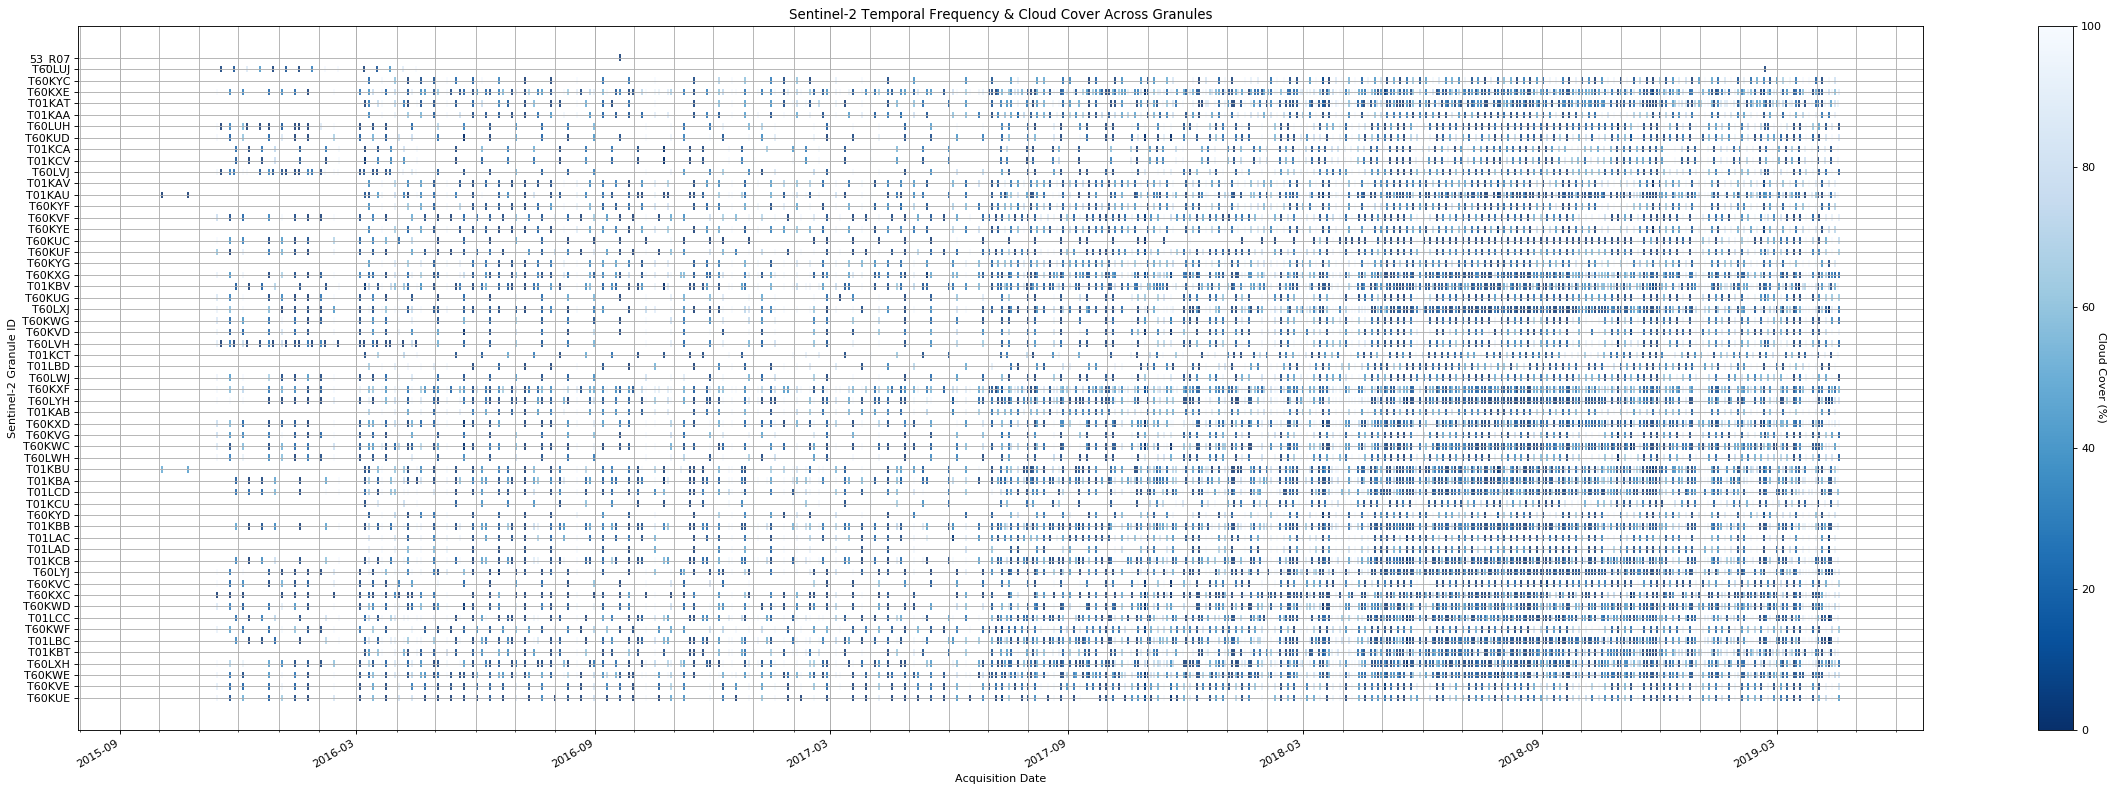

In [610]:
import matplotlib.colors as mcolors
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, ax = plt.subplots(figsize=(30,10),dpi=80)
fig.autofmt_xdate()

df = pd.read_csv('../Search_Discovery/Fiji_S2_L1C_ESA.csv')
df['s1platform'] = df['identifier'].str[:3]
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)
df['granules'] = df.identifier.str[38:44]

img1 = ax.scatter(df['Acquisition Date'].values, df['granules'].values.astype(str), marker='|', c=df['cloudcoverpercentage'].values, cmap='Blues_r');


cbar = fig.colorbar(img1, ax=ax)
cbar.set_label('Cloud Cover (%)', rotation=270)
ax.set_ylabel("Sentinel-2 Granule ID");
ax.set_xlabel("Acquisition Date");
ax.set_title('Sentinel-2 Temporal Frequency & Cloud Cover Across Granules');
ax.xaxis.set_major_locator(mdates.AutoDateLocator());
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m") ); 
ax.xaxis.set_minor_locator(mdates.MonthLocator());
#ax.xaxis.set_minor_formatter(DateFormatter(""%Y-%m"") ); 
ax.grid(which='both')
fig.tight_layout()

#fig.savefig('../Search_Discovery/Fiji_S1_tempdistribution_polarisation');

**The 'nitty gritty' of data volumes and potential storage requirements.**

Total No. Scenes:  12570


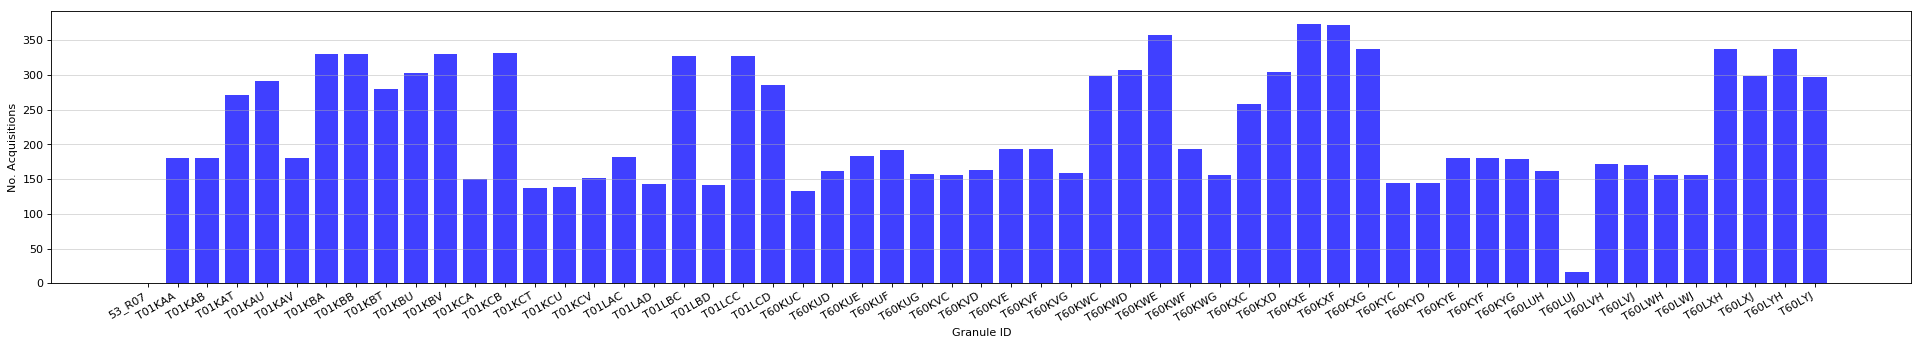

In [624]:
fig, ax = plt.subplots(figsize=(30,5),dpi=80)
fig.autofmt_xdate()

df = pd.read_csv('../Search_Discovery/Fiji_S2_L1C_ESA.csv')
df['s1platform'] = df['identifier'].str[:3]
df['granuleid']= df.identifier.str[38:44]
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)

#df = df[df['Beam Mode'].isin(['IW'])]

#df = df[(df['Acquisition Date']>datetime.date(2018,1,1)) & (df['Acquisition Date']<datetime.date(2019,1,1))]

print ( 'Total No. Scenes: ', df.shape[0] )

#color_labels = df['Ascending or Descending?'].unique()
#color_labels = [ df[df['Path Number'].isin([str(i)])]['Ascending or Descending?'].unique()[0] for i in df['Path Number'].value_counts().index.values ]
#def_cols = ['red','green','blue','purple','yellow']
#color_map = dict(zip(color_labels, def_cols[:len(color_labels)]))
#print ( '\n', 'No. Scenes per Track', '\n', color_map )

#leg_patches = []
i = 0
for ctype, data in df.groupby('granuleid'):
        
    ax.bar(str(ctype),data.shape[0],
          facecolor='blue',
          alpha=0.75)
    
    i+=1
    
ax.grid(axis='y', alpha=0.5)
ax.set_xlabel('Granule ID');
ax.set_ylabel('No. Acquisitions');


Total Volume (~GB):  465.09


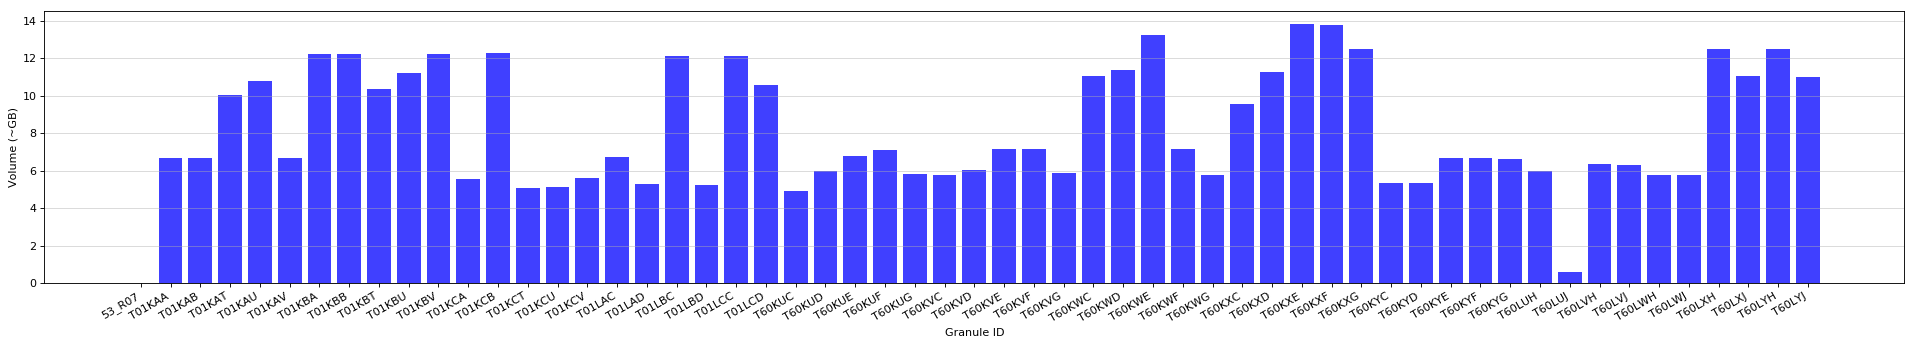

In [633]:
fig, ax = plt.subplots(figsize=(30,5),dpi=80)
fig.autofmt_xdate()

df = pd.read_csv('../Search_Discovery/Fiji_S2_L1C_ESA.csv')
df['s1platform'] = df['identifier'].str[:3]
df['granuleid']= df.identifier.str[38:44]
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)

#df = df[df['Beam Mode'].isin(['IW'])]

#df = df[(df['Acquisition Date']>datetime.date(2018,1,1)) & (df['Acquisition Date']<datetime.date(2019,1,1))]

print ( 'Total Volume (~GB): ', df.size.sum()/1000 )

#color_labels = df['Ascending or Descending?'].unique()
#color_labels = [ df[df['Path Number'].isin([str(i)])]['Ascending or Descending?'].unique()[0] for i in df['Path Number'].value_counts().index.values ]
#def_cols = ['red','green','blue','purple','yellow']
#color_map = dict(zip(color_labels, def_cols[:len(color_labels)]))
#print ( '\n', 'No. Scenes per Track', '\n', color_map )

#leg_patches = []
i = 0
for ctype, data in df.groupby('granuleid'):
        
    ax.bar(str(ctype),data.size.sum()/1000,
          facecolor='blue',
          alpha=0.75)
    
    i+=1

ax.grid(axis='y', alpha=0.5)
ax.set_xlabel('Granule ID');
ax.set_ylabel('Volume (~GB)');


Average File Size (~GB):  465.09 +/ 0.0


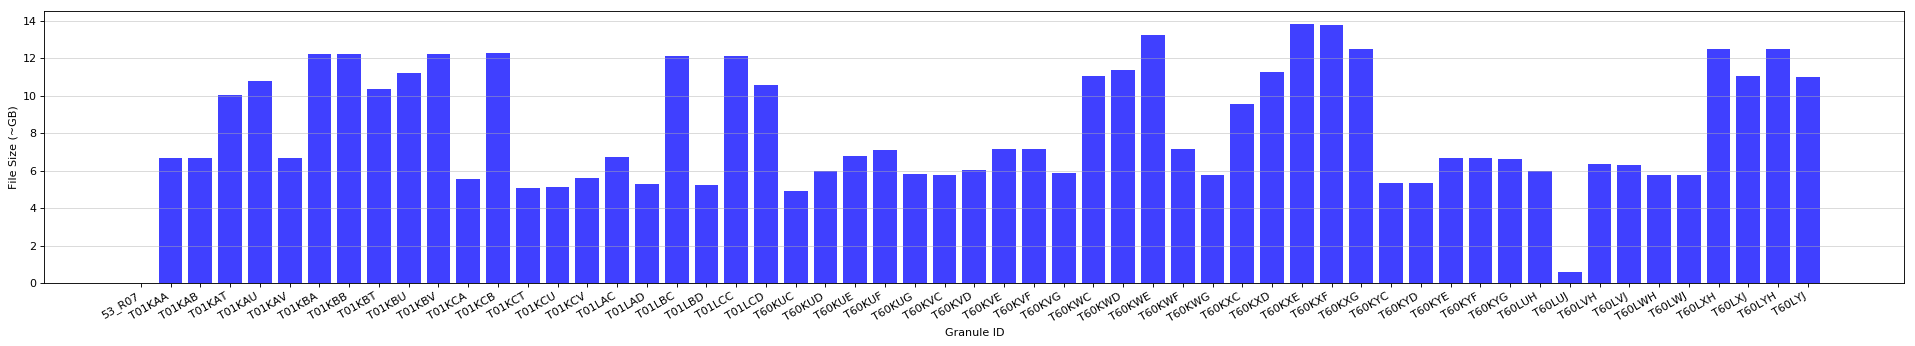

In [632]:
fig, ax = plt.subplots(figsize=(30,5),dpi=80)
fig.autofmt_xdate()

df = pd.read_csv('../Search_Discovery/Fiji_S2_L1C_ESA.csv')
df['s1platform'] = df['identifier'].str[:3]
df['granuleid']= df.identifier.str[38:44]
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)

#df = df[df['Beam Mode'].isin(['IW'])]

#df = df[(df['Acquisition Date']>datetime.date(2018,1,1)) & (df['Acquisition Date']<datetime.date(2019,1,1))]

print ( 'Average File Size (~GB): ', df.size.mean()/1000, '+/' )

#color_labels = df['Ascending or Descending?'].unique()
#color_labels = [ df[df['Path Number'].isin([str(i)])]['Ascending or Descending?'].unique()[0] for i in df['Path Number'].value_counts().index.values ]
#def_cols = ['red','green','blue','purple','yellow']
#color_map = dict(zip(color_labels, def_cols[:len(color_labels)]))
#print ( '\n', 'No. Scenes per Track', '\n', color_map )

#leg_patches = []
i = 0
for ctype, data in df.groupby('granuleid'):
        
    ax.bar(str(ctype),data.size.mean()/1000,
          facecolor='blue',
          alpha=0.75)
    
    i+=1

ax.grid(axis='y', alpha=0.5)
ax.set_xlabel('Granule ID');
ax.set_ylabel('File Size (~GB)');


### **S2 - PoC**

In [1]:
pocgran = 'T60KXF'

Investigating just a single tile for the PoC (T60KXF), it's evident from the image extents that it covers an area of overlap across S2 tracks. The granule appears to now be routinely captured in two parts with approx. 60-40% split. It makes this location an interesting example for the DC functionality.


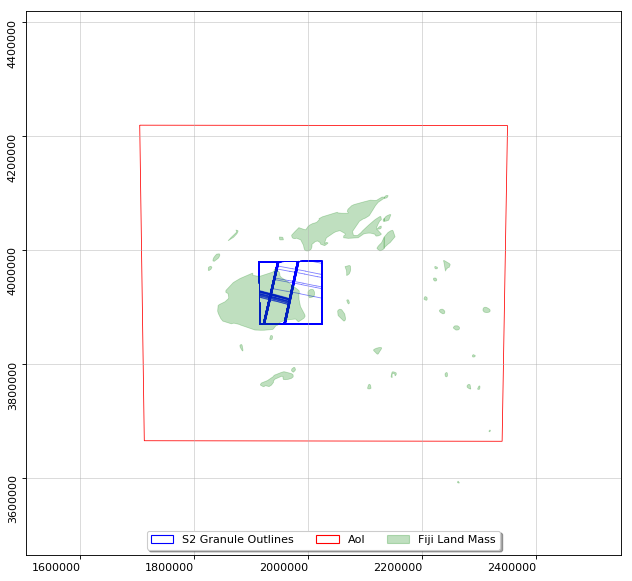

In [796]:
fig, ax = plt.subplots(figsize=(10,10),dpi=80)
fig.autofmt_xdate()
leg_patches = []

df = pd.read_csv('../Search_Discovery/Fiji_S2_L1C_ESA.csv')
df['s1platform'] = df['identifier'].str[:3]
df['granuleid']= df.identifier.str[38:44]
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)

df = df[df.granuleid.isin([pocgran])]
#df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2020,1,1))]


df['coordinates'] = df['geometry'].apply(wkt.loads)
# create geodataframe
gdf = geopandas.GeoDataFrame(df, geometry='coordinates', crs=('epsg:4326'))
# Repro dataframe geometry
df['repro'] = df['coordinates'].apply(lambda x: reproject(str(x)))
# recreate geodataframe with reprojected coordinates
df['repro'] = df['repro'].apply(wkt.loads)
gdf = geopandas.GeoDataFrame(df, geometry='repro', crs=('epsg:3460'))

gdf.plot(edgecolor='b',
         facecolor='none',
         ax = ax, 
         lw=0.75,
         alpha=0.5)

leg_patches.append(mpatches.Patch(facecolor='none',edgecolor='blue', label='S2 Granule Outlines'))

# Plot AoI
aoigdf.plot(facecolor="none", edgecolor='r', lw=0.7, ax=ax);
leg_patches.append(mpatches.Patch(facecolor='none',edgecolor='red', label='AoI'))
# Use the borders again
borders.plot(facecolor="g", edgecolor='g', alpha=0.25, lw=0.7, ax=ax);
leg_patches.append(mpatches.Patch(facecolor='g',edgecolor='g', alpha=0.25, label='Fiji Land Mass'))

ax.legend(handles=leg_patches, loc='lower center', shadow=True, ncol=5);
ax.grid(alpha=0.5);
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);
ax.set_xlim(aoigdf.bounds.minx.values[0]-200000, aoigdf.bounds.maxx.values[0]+200000);
ax.set_ylim(aoigdf.bounds.miny.values[0]-200000, aoigdf.bounds.maxy.values[0]+200000);

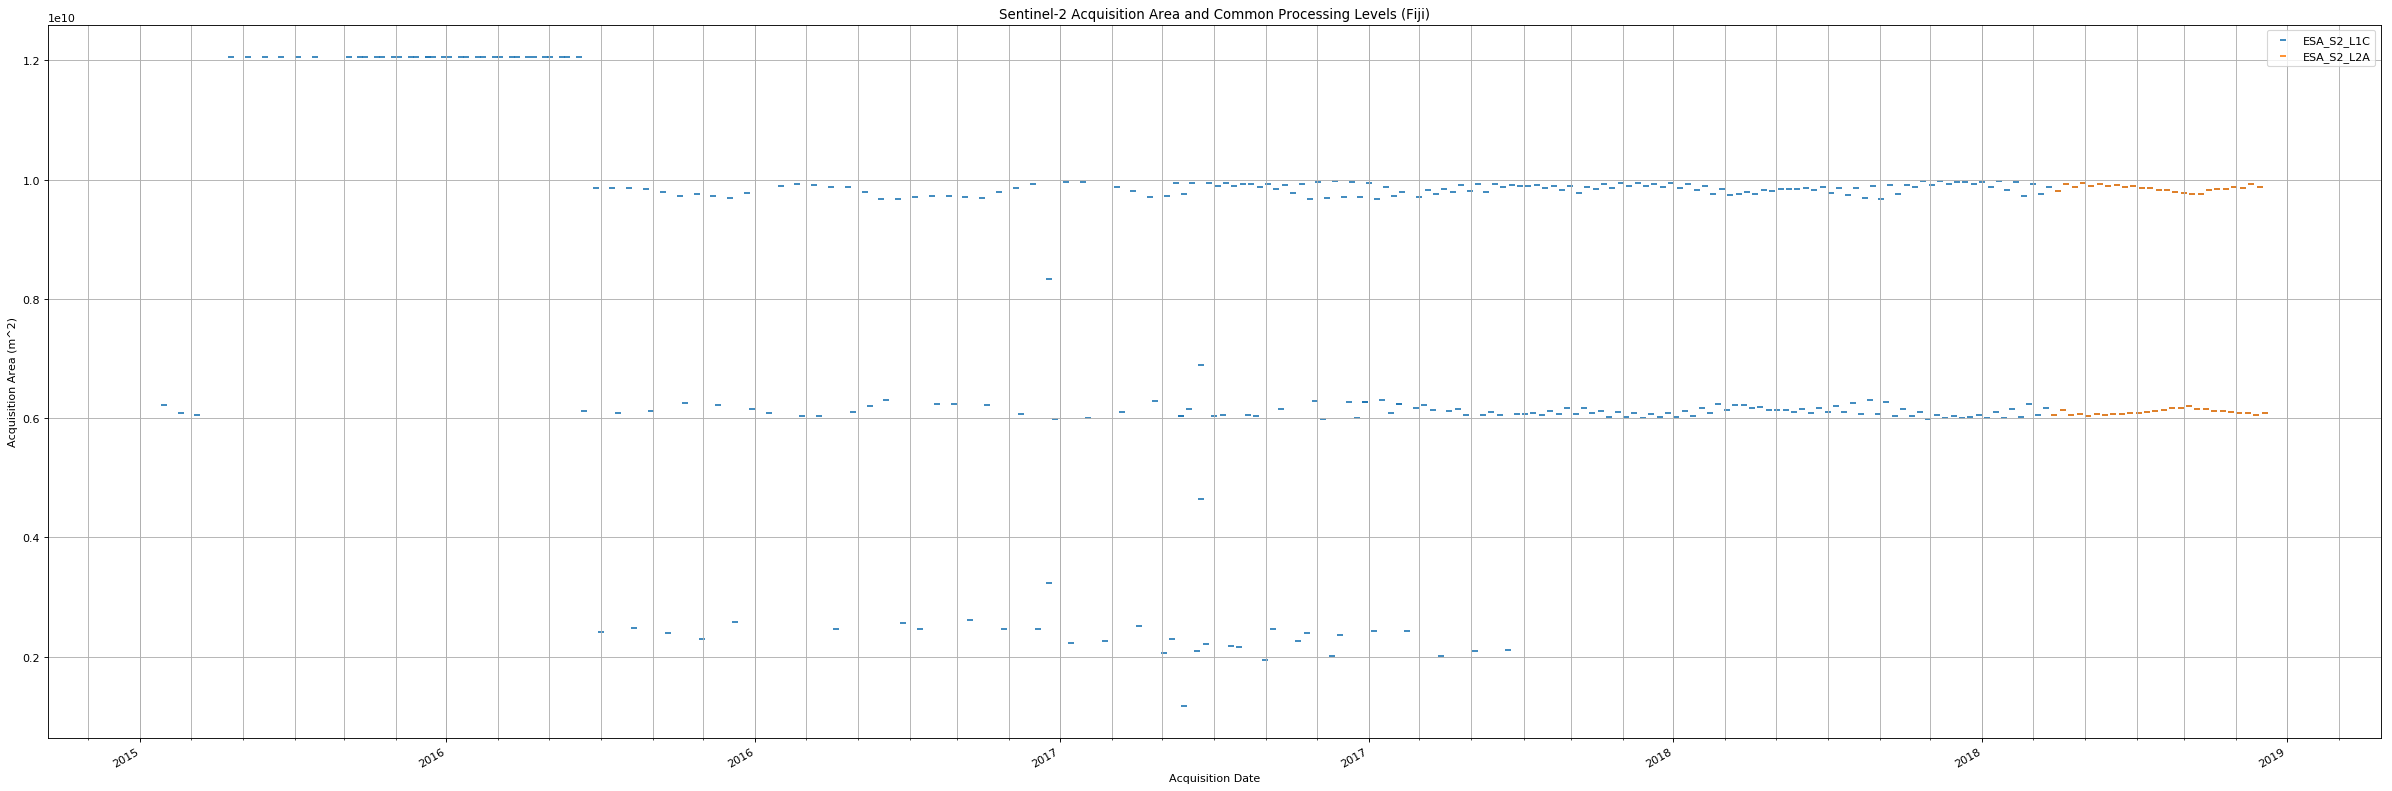

In [42]:
fig, ax = plt.subplots(figsize=(30,10),dpi=80)
fig.autofmt_xdate()

df = pd.read_csv('../Search_Discovery/Fiji_S2_L1C_ESA.csv')
df['s1platform'] = df['identifier'].str[:3]
df['granuleid']= df.identifier.str[38:44]
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)

df = df[df.granuleid.isin([pocgran])]
df['coordinates'] = df['geometry'].apply(wkt.loads)
# create geodataframe
gdf = geopandas.GeoDataFrame(df, geometry='coordinates', crs=('epsg:4326'))
# Repro dataframe geometry
df['repro'] = df['coordinates'].apply(lambda x: reproject(str(x)))
# recreate geodataframe with reprojected coordinates
df['repro'] = df['repro'].apply(wkt.loads)
gdf = geopandas.GeoDataFrame(df, geometry='repro', crs=('epsg:3460'))
gdf['area'] = gdf['repro'].area
ax.scatter(df['Acquisition Date'].values, df['area'].values, marker='_');

df = pd.read_csv('../Search_Discovery/Fiji_S2_L2A_ESA.csv')
df['s1platform'] = df['identifier'].str[:3]
df['granuleid']= df.identifier.str[38:44]
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)

df = df[df.granuleid.isin([pocgran])]
df['coordinates'] = df['geometry'].apply(wkt.loads)
# create geodataframe
gdf = geopandas.GeoDataFrame(df, geometry='coordinates', crs=('epsg:4326'))
# Repro dataframe geometry
df['repro'] = df['coordinates'].apply(lambda x: reproject(str(x)))
# recreate geodataframe with reprojected coordinates
df['repro'] = df['repro'].apply(wkt.loads)
gdf = geopandas.GeoDataFrame(df, geometry='repro', crs=('epsg:3460'))
gdf['area'] = gdf['repro'].area
ax.scatter(df['Acquisition Date'].values, df['area'].values, marker='_');


ax.set_ylabel("Acquisition Area (m^2)");
ax.set_xlabel("Acquisition Date");
ax.legend(['ESA_S2_L1C','ESA_S2_L2A','USGS_L7','USGS_L4-5TM','USGS_L1-4MSS']);
ax.set_title('Sentinel-2 Acquisition Area and Common Processing Levels (Fiji)');
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y") ) 
ax.xaxis.set_minor_locator(mdates.MonthLocator())
#ax.xaxis.set_minor_formatter(DateFormatter("%m") ) 
ax.grid(which='both')
fig.tight_layout()
#fig.savefig('../Search_Discovery/LS_Summary_CC_AqNo');

In [43]:
df = pd.read_csv('../Search_Discovery/Fiji_S2_L1C_ESA.csv')
df['s1platform'] = df['identifier'].str[:3]
df['granuleid']= df.identifier.str[38:44]
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)


print ( 'Full archive for PoC L1C granule: ', df.size/1000, '~GB', 'n: ', df.shape[0], 'avg: ', df.size/df.shape[0] )

df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2020,1,1))]

print ( '2019 current archive for PoC L1C granule: ', df.size/1000, '~GB', 'n: ', df.shape[0], 'avg: ', df.size/df.shape[0] )

df = pd.read_csv('../Search_Discovery/Fiji_S2_L2A_ESA.csv')
df['s1platform'] = df['identifier'].str[:3]
df['granuleid']= df.identifier.str[38:44]
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)

print ( 'Full archive for PoC L1C granule: ', df.size/1000, '~GB', 'n: ', df.shape[0], 'avg: ', df.size/df.shape[0] )

df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2020,1,1))]

print ( '2019 current archive for PoC L1C granule: ', df.size/1000, '~GB', 'n: ', df.shape[0], 'avg: ', df.size/df.shape[0] )

#df.hist(column='size', rwidth=0.95)

Full archive for PoC L1C granule:  465.09 ~GB n:  12570 avg:  37.0
2019 current archive for PoC L1C granule:  64.084 ~GB n:  1732 avg:  37.0
Full archive for PoC L1C granule:  79.131 ~GB n:  2029 avg:  39.0
2019 current archive for PoC L1C granule:  67.548 ~GB n:  1732 avg:  39.0


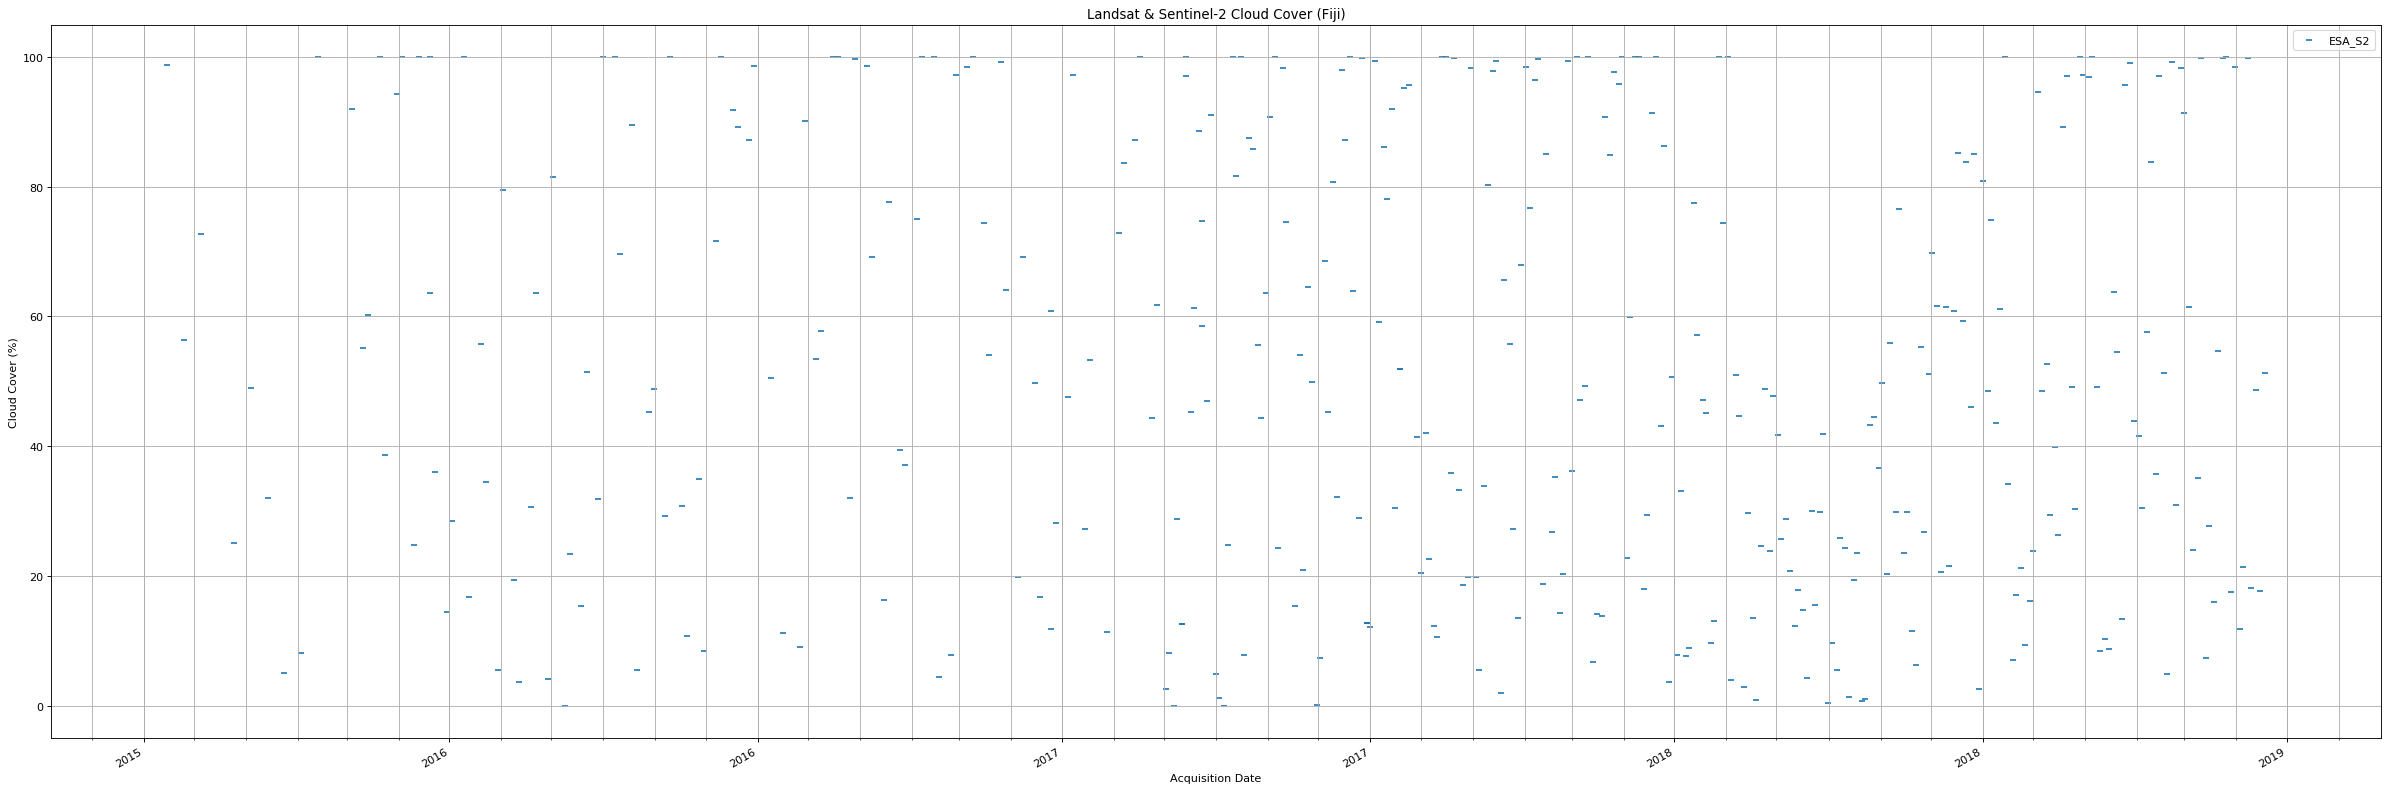

In [44]:
fig, ax = plt.subplots(figsize=(30,10),dpi=80)
fig.autofmt_xdate()

df = pd.read_csv('../Search_Discovery/Fiji_S2_L1C_ESA.csv')
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)
df['granuleid']= df.identifier.str[38:44]
df = df[df.granuleid.isin([pocgran])]

ax.scatter(df['Acquisition Date'].values, df[''].values, marker='_');


ax.set_ylabel("File Size (aesd)");
ax.set_xlabel("Acquisition Date");
ax.legend(['ESA_S2','USGS_L8','USGS_L7','USGS_L4-5TM','USGS_L1-4MSS']);
ax.set_title('Landsat & Sentinel-2 Cloud Cover (Fiji)');
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y") ) 
ax.xaxis.set_minor_locator(mdates.MonthLocator())
#ax.xaxis.set_minor_formatter(DateFormatter("%m") ) 
ax.grid(which='both')
fig.tight_layout()
fig.savefig('../Search_Discovery/LS_Summary_CC_AqNo');

In [77]:
df = pd.read_csv('../Search_Discovery/Fiji_S2_L1C_ESA.csv')
#print('ESA GRD \n', 'No. Prods: ', len(df))
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%dT%H:%M:%S', utc=True)
# Convert dates into datetime objects
df['granuleid']= df.identifier.str[38:44]
df = df[df.granuleid.isin([pocgran])]

print ( df.shape )
df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2019,1,15))]
print ( df.shape )

sorted(df.identifier.values)

(372, 36)
(6, 36)


['S2A_MSIL1C_20190104T221931_N0207_R029_T60KXF_20190104T232546',
 'S2A_MSIL1C_20190107T223001_N0207_R072_T60KXF_20190107T233849',
 'S2A_MSIL1C_20190114T221941_N0207_R029_T60KXF_20190114T232745',
 'S2B_MSIL1C_20190102T223009_N0207_R072_T60KXF_20190102T233714',
 'S2B_MSIL1C_20190109T221939_N0207_R029_T60KXF_20190109T233138',
 'S2B_MSIL1C_20190112T223009_N0207_R072_T60KXF_20190112T234004']

In [3]:
df = pd.read_csv('../Search_Discovery/Fiji_S2_L1C_GCL.csv')
#print('ASF GRD \n', 'No. Prods: ', len(df), 'Vol Prods (TB): ', df['Size (MB)'].sum()/1000000)
# Convert dates into datetime objects
df['Acquisition Date'] = pd.to_datetime(df['SENSING_TIME'], format='%Y-%m-%dT%H:%M:%S', utc=True)
print ('No. GCloud prods before removing products of NaN size', df.shape[0] )
df = df.dropna(subset=['TOTAL_SIZE'])

df['granuleid']= df.PRODUCT_ID.str[38:44]
df = df[df.granuleid.isin([pocgran])]

print ( df.shape )
df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2019,1,15))]
print ( df.shape )

df.head(2)

sorted(df.PRODUCT_ID.values)

No. GCloud prods before removing products of NaN size 12789
(336, 17)
(6, 17)


['S2A_MSIL1C_20190104T221931_N0207_R029_T60KXF_20190104T232546',
 'S2A_MSIL1C_20190107T223001_N0207_R072_T60KXF_20190107T233849',
 'S2A_MSIL1C_20190114T221941_N0207_R029_T60KXF_20190114T232745',
 'S2B_MSIL1C_20190102T223009_N0207_R072_T60KXF_20190102T233714',
 'S2B_MSIL1C_20190109T221939_N0207_R029_T60KXF_20190109T233138',
 'S2B_MSIL1C_20190112T223009_N0207_R072_T60KXF_20190112T234004']

In [6]:
from sen2cor_full import download_s2_frm_grans

download_s2_frm_grans(df, '../Data/S2_GCloud/')


gs://gcp-public-data-sentinel-2/tiles/60/K/XF/S2B_MSIL1C_20190102T223009_N0207_R072_T60KXF_20190102T233714.SAFE
gs://gcp-public-data-sentinel-2/tiles/60/K/XF/S2A_MSIL1C_20190104T221931_N0207_R029_T60KXF_20190104T232546.SAFE
gs://gcp-public-data-sentinel-2/tiles/60/K/XF/S2A_MSIL1C_20190107T223001_N0207_R072_T60KXF_20190107T233849.SAFE
gs://gcp-public-data-sentinel-2/tiles/60/K/XF/S2B_MSIL1C_20190109T221939_N0207_R029_T60KXF_20190109T233138.SAFE
gs://gcp-public-data-sentinel-2/tiles/60/K/XF/S2B_MSIL1C_20190112T223009_N0207_R072_T60KXF_20190112T234004.SAFE
gs://gcp-public-data-sentinel-2/tiles/60/K/XF/S2A_MSIL1C_20190114T221941_N0207_R029_T60KXF_20190114T232745.SAFE


(12570, 36)
(489, 36)
(12518, 17)
(495, 17)


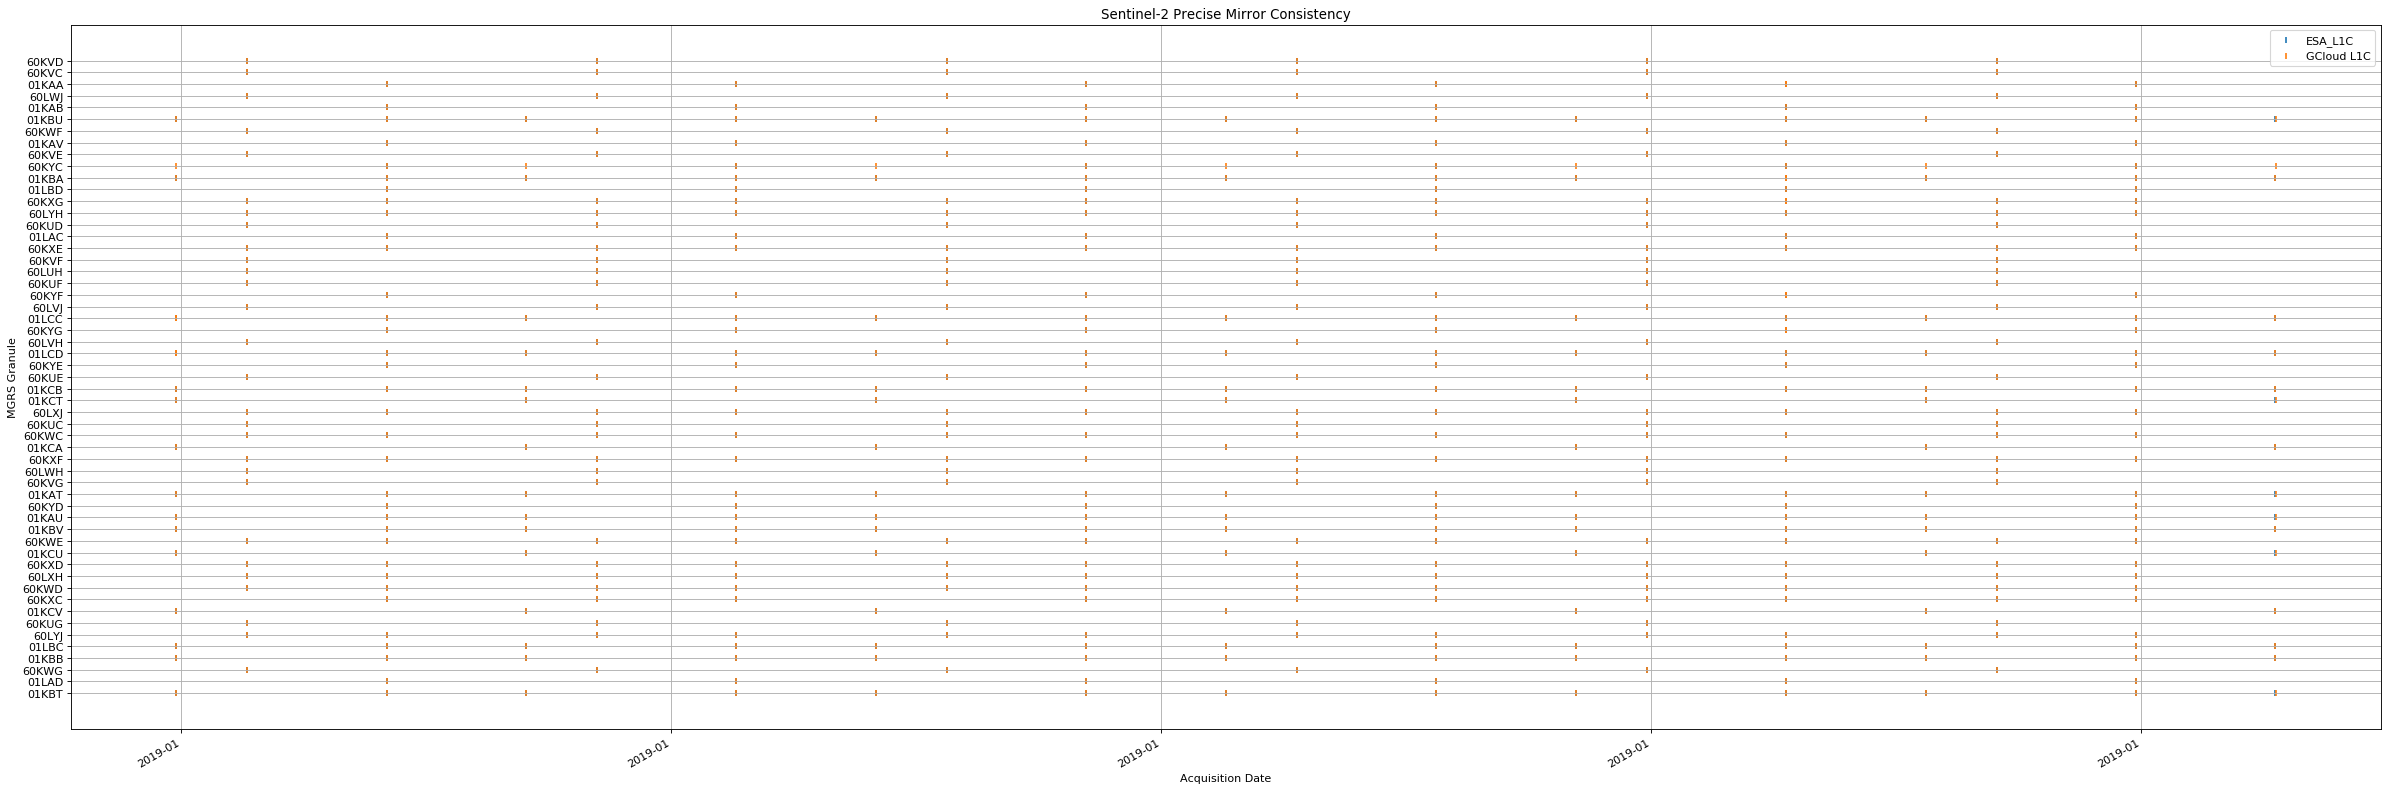

In [68]:
fig, ax = plt.subplots(figsize=(30,10),dpi=80)
fig.autofmt_xdate()

df = pd.read_csv('../Search_Discovery/Fiji_S2_L1C_ESA.csv')
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)
df['granules'] = df.identifier.str[39:44]
print ( df.shape )
df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2019,2,1))]
print ( df.shape )
ax.scatter(df['Acquisition Date'].values, df['granules'].values, marker='|');

df = pd.read_csv('../Search_Discovery/Fiji_S2_L1C_GCL.csv')
df['Acquisition Date'] = pd.to_datetime(df['SENSING_TIME'], format='%Y-%m-%d', utc=True)
df['granules'] = df['MGRS_TILE']
# remove files showing as NaN size
df = df.dropna(subset=['TOTAL_SIZE'])
print ( df.shape )
df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2019,2,1))]
print ( df.shape )
ax.scatter(df['Acquisition Date'].values, df['granules'].values, marker='|');

ax.set_ylabel('MGRS Granule');
ax.set_xlabel("Acquisition Date");
ax.legend(['ESA_L1C','GCloud L1C','USGS_L4-5TM','USGS_L1-4MSS']);
ax.set_title("Sentinel-2 Precise Mirror Consistency");
ax.xaxis.set_major_locator(mdates.AutoDateLocator());
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m") ); 
ax.grid(which='both')
fig.tight_layout()
#fig.savefig('../Search_Discovery/Fiji_S1_tempdistribution_orbitdirection');

# Landsat

### **Query:** USGS

In [69]:
# Read LS acquisition .csv's, subset to matching frames (path,rows), write to new subset .csv's for efficiency later.
# csvs taken from 

pr = geopandas.read_file('../Search_Discovery/USGS_Landsat/Fiji_Landsat_PathRow_fijicrs.geojson')

df = pd.read_csv('../Search_Discovery/USGS_Landsat/LANDSAT_8_C1.csv.gz')
df = df[df.row.isin(pr.ROW.values)&df.path.isin(pr.PATH.values)]
df.to_csv('../Search_Discovery/USGS_Landsat/LANDSAT_8_C1_fiji.csv')

df = pd.read_csv('../Search_Discovery/USGS_Landsat/LANDSAT_ETM_C1.csv.gz')
df = df[df.row.isin(pr.ROW.values)&df.path.isin(pr.PATH.values)]
df.to_csv('../Search_Discovery/USGS_Landsat/LANDSAT_ETM_C1_fiji.csv')

df = pd.read_csv('../Search_Discovery/USGS_Landsat/LANDSAT_TM_C1.csv.gz')
df = df[df.row.isin(pr.ROW.values)&df.path.isin(pr.PATH.values)]
df.to_csv('../Search_Discovery/USGS_Landsat/LANDSAT_TM_C1_fiji.csv')

df = pd.read_csv('../Search_Discovery/USGS_Landsat/LANDSAT_MSS_C1.csv.gz')
df = df[df.row.isin(pr.ROW.values)&df.path.isin(pr.PATH.values)]
df.to_csv('../Search_Discovery/USGS_Landsat/LANDSAT_MSS_C1_fiji.csv')

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

### **Data Availability:** USGS(, Google, AWS tbc)
Are there consistent data volumes across data sources and processing levels (can we be confident in routinely downloading SLC products from ASF)?

Landsat 8 
 No. Prods:  1719
Landsat ETM 
 No. Prods:  1362
Landsat TM 
 No. Prods:  142
Landsat MSS 
 No. Prods:  86


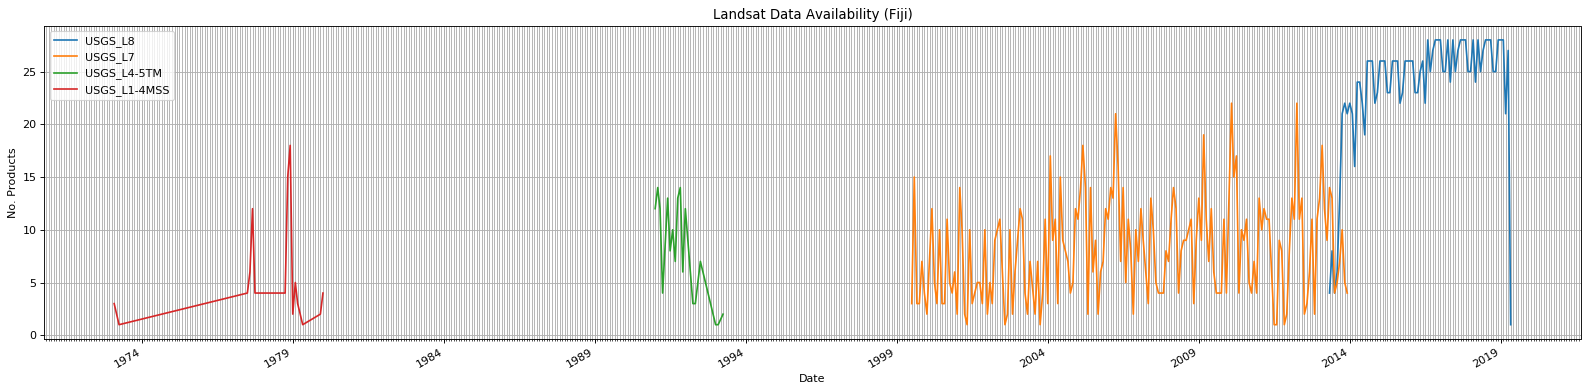

In [6]:
fig, ax = plt.subplots(figsize=(20,5),dpi=80)
fig.autofmt_xdate()

df = pd.read_csv('../Search_Discovery/USGS_Landsat/LANDSAT_8_C1_fiji.csv')
print('Landsat 8 \n', 'No. Prods: ', len(df))
df['Acquisition Date'] = pd.to_datetime(df['acquisitionDate'], format='%Y-%m-%d', utc=True)
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values);

df = pd.read_csv('../Search_Discovery/USGS_Landsat/LANDSAT_ETM_C1_fiji.csv')
print('Landsat ETM \n', 'No. Prods: ', len(df))
df['Acquisition Date'] = pd.to_datetime(df['acquisitionDate'], format='%Y-%m-%d', utc=True)
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values);

df = pd.read_csv('../Search_Discovery/USGS_Landsat/LANDSAT_TM_C1_fiji.csv')
print('Landsat TM \n', 'No. Prods: ', len(df))
df['Acquisition Date'] = pd.to_datetime(df['acquisitionDate'], format='%Y-%m-%d', utc=True)
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values);

df = pd.read_csv('../Search_Discovery/USGS_Landsat/LANDSAT_MSS_C1_fiji.csv')
print('Landsat MSS \n', 'No. Prods: ', len(df))
df['Acquisition Date'] = pd.to_datetime(df['acquisitionDate'], format='%Y-%m-%d', utc=True)
df = df['Acquisition Date'].groupby(df['Acquisition Date'].dt.to_period("M")).agg('count')
df.index.to_timestamp(freq ='M').values
ax.plot(df.index.to_timestamp(freq ='M').values, df.values);

ax.set_ylabel("No. Products");
ax.set_xlabel("Date");
ax.legend(['USGS_L8','USGS_L7','USGS_L4-5TM','USGS_L1-4MSS']);
ax.set_title('Landsat Data Availability (Fiji)');
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y") ) 
ax.xaxis.set_minor_locator(mdates.MonthLocator())
#ax.xaxis.set_minor_formatter(DateFormatter("%m") ) 
ax.grid(which='both')
fig.tight_layout()
fig.savefig('../Search_Discovery/LS_Summary_AqNo');

Distribution of frames...

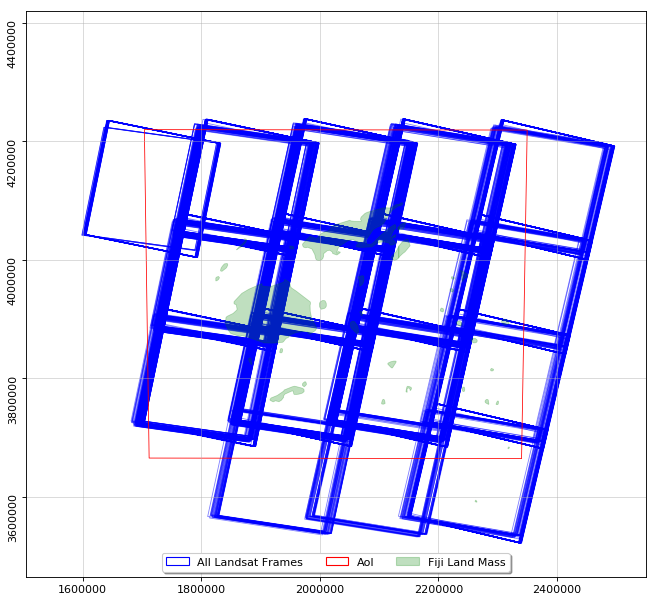

In [7]:
fig, ax = plt.subplots(figsize=(10,10),dpi=80)
fig.autofmt_xdate
leg_patches = []

df = pd.read_csv('../Search_Discovery/USGS_Landsat/LANDSAT_8_C1_fiji.csv')
df['pr'] = df.path.astype(str) + df.row.astype(str)

#for i in df.columns: print ( i )

df['ns'] = df[['upperRightCornerLongitude','upperRightCornerLatitude']].values.tolist()
df['ne'] = df[['lowerRightCornerLongitude','lowerRightCornerLatitude']].values.tolist()
df['fs'] = df[['lowerLeftCornerLongitude','lowerLeftCornerLatitude']].values.tolist()
df['fe'] = df[['upperLeftCornerLongitude','upperLeftCornerLatitude']].values.tolist()

df['coordinates'] = list(zip(df['ns'],df['fe'],df['fs'],df['ne'],df['ns']))
df['coordinates'] = df['coordinates'].apply(Polygon)
# create geodataframe
gdf = geopandas.GeoDataFrame(df, geometry='coordinates', crs=('epsg:4326'))
# Repro dataframe geometry
df['repro'] = df['coordinates'].apply(lambda x: reproject(str(x)))
# recreate geodataframe with reprojected coordinates
df['repro'] = df['repro'].apply(wkt.loads)
gdf = geopandas.GeoDataFrame(df, geometry='repro', crs=('epsg:3460'))

gdf.plot(edgecolor='blue',
         facecolor='none', 
         lw=0.75,
         alpha=0.5,
         ax=ax)



df = pd.read_csv('../Search_Discovery/USGS_Landsat/LANDSAT_ETM_C1_fiji.csv')
df['pr'] = df.path.astype(str) + df.row.astype(str)

#for i in df.columns: print ( i )

df['ns'] = df[['upperRightCornerLongitude','upperRightCornerLatitude']].values.tolist()
df['ne'] = df[['lowerRightCornerLongitude','lowerRightCornerLatitude']].values.tolist()
df['fs'] = df[['lowerLeftCornerLongitude','lowerLeftCornerLatitude']].values.tolist()
df['fe'] = df[['upperLeftCornerLongitude','upperLeftCornerLatitude']].values.tolist()

df['coordinates'] = list(zip(df['ns'],df['fe'],df['fs'],df['ne'],df['ns']))
df['coordinates'] = df['coordinates'].apply(Polygon)
# create geodataframe
gdf = geopandas.GeoDataFrame(df, geometry='coordinates', crs=('epsg:4326'))
# Repro dataframe geometry
df['repro'] = df['coordinates'].apply(lambda x: reproject(str(x)))
# recreate geodataframe with reprojected coordinates
df['repro'] = df['repro'].apply(wkt.loads)
gdf = geopandas.GeoDataFrame(df, geometry='repro', crs=('epsg:3460'))

gdf.plot(edgecolor='blue',
         facecolor='none', 
         lw=0.75,
         alpha=0.5,
         ax=ax)


df = pd.read_csv('../Search_Discovery/USGS_Landsat/LANDSAT_TM_C1_fiji.csv')
df['pr'] = df.path.astype(str) + df.row.astype(str)

#for i in df.columns: print ( i )

df['ns'] = df[['upperRightCornerLongitude','upperRightCornerLatitude']].values.tolist()
df['ne'] = df[['lowerRightCornerLongitude','lowerRightCornerLatitude']].values.tolist()
df['fs'] = df[['lowerLeftCornerLongitude','lowerLeftCornerLatitude']].values.tolist()
df['fe'] = df[['upperLeftCornerLongitude','upperLeftCornerLatitude']].values.tolist()

df['coordinates'] = list(zip(df['ns'],df['fe'],df['fs'],df['ne'],df['ns']))
df['coordinates'] = df['coordinates'].apply(Polygon)
# create geodataframe
gdf = geopandas.GeoDataFrame(df, geometry='coordinates', crs=('epsg:4326'))
# Repro dataframe geometry
df['repro'] = df['coordinates'].apply(lambda x: reproject(str(x)))
# recreate geodataframe with reprojected coordinates
df['repro'] = df['repro'].apply(wkt.loads)
gdf = geopandas.GeoDataFrame(df, geometry='repro', crs=('epsg:3460'))

gdf.plot(edgecolor='blue',
         facecolor='none', 
         lw=0.75,
         alpha=0.5,
         ax=ax)


leg_patches.append(mpatches.Patch(facecolor='none',edgecolor='blue', label='All Landsat Frames'))


# Plot AoI
aoigdf.plot(facecolor="none", edgecolor='r', lw=0.7, ax=ax);
leg_patches.append(mpatches.Patch(facecolor='none',edgecolor='red', label='AoI'))
# Use the borders again
borders.plot(facecolor="g", edgecolor='g', alpha=0.25, lw=0.7, ax=ax);
leg_patches.append(mpatches.Patch(facecolor='g',edgecolor='g', alpha=0.25, label='Fiji Land Mass'))

ax.legend(handles=leg_patches, loc='lower center', shadow=True, ncol=6);
ax.grid(alpha=0.5);
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);
ax.set_xlim(aoigdf.bounds.minx.values[0]-200000, aoigdf.bounds.maxx.values[0]+200000);
ax.set_ylim(aoigdf.bounds.miny.values[0]-200000, aoigdf.bounds.maxy.values[0]+200000);

What's the likelihood of retreiving useful (cloud-free) data across each frame...?

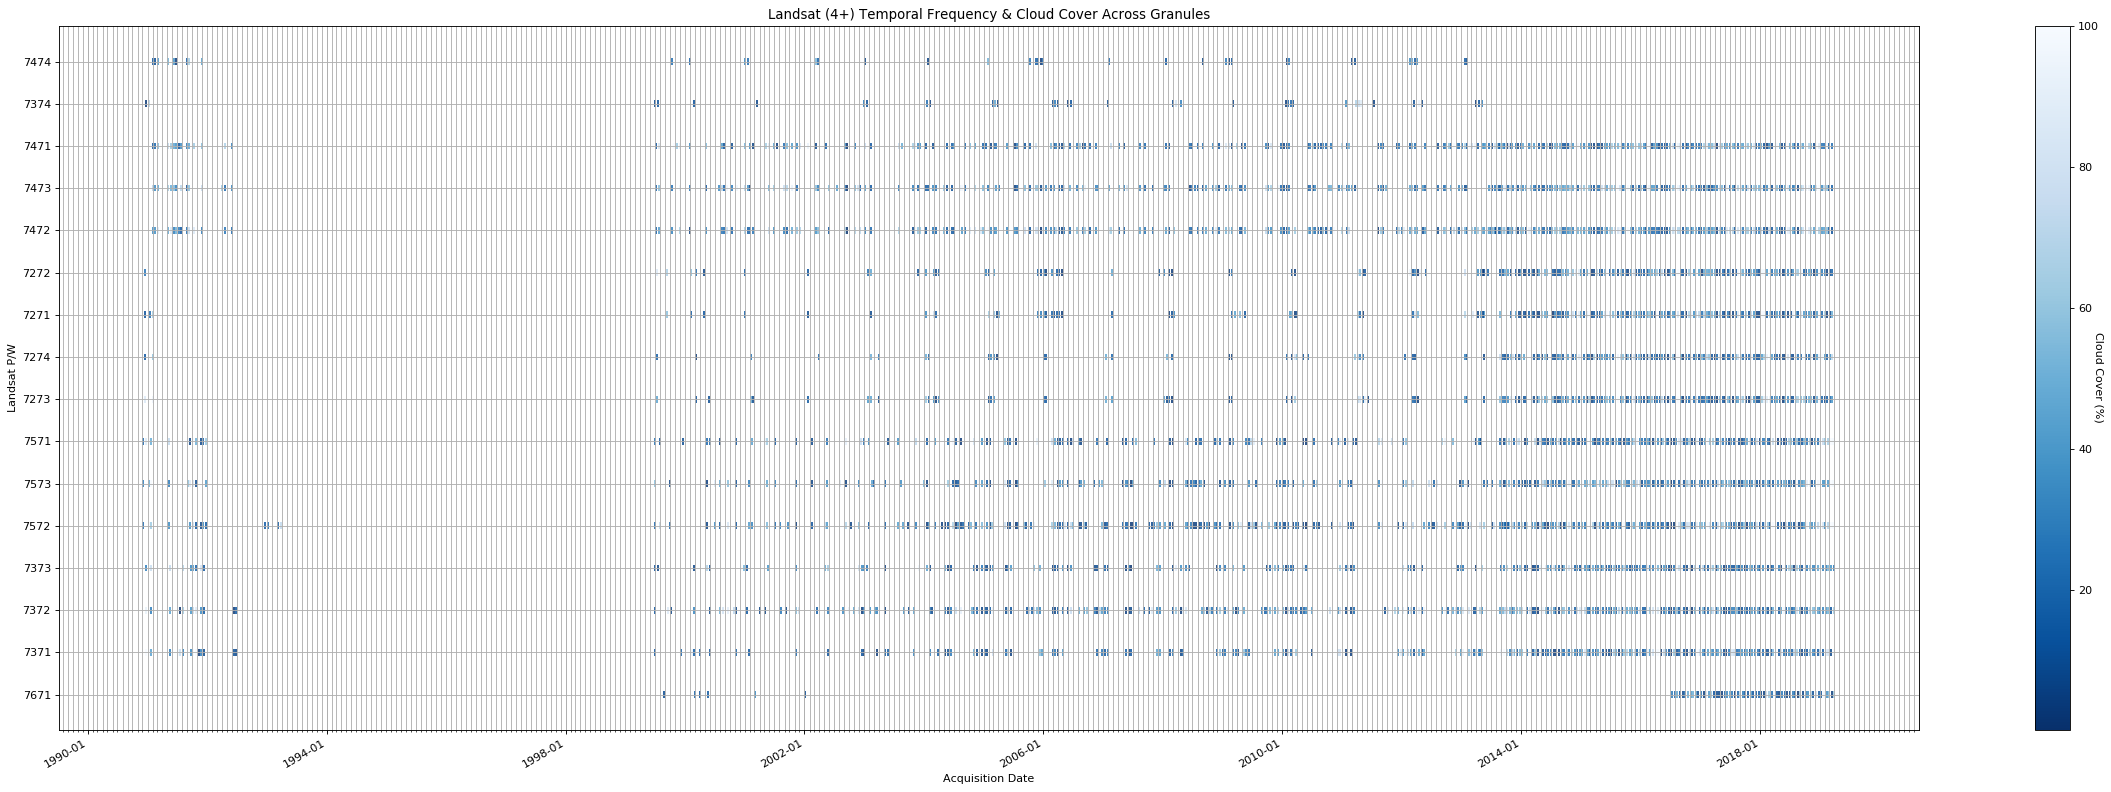

In [8]:
import matplotlib.colors as mcolors
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, ax = plt.subplots(figsize=(30,10),dpi=80)
fig.autofmt_xdate()

df = pd.read_csv('../Search_Discovery/USGS_Landsat/LANDSAT_8_C1_fiji.csv')
df['Acquisition Date'] = pd.to_datetime(df['acquisitionDate'], format='%Y-%m-%d', utc=True)
df['granules'] = df.path.astype(str) + df.row.astype(str)

img1 = ax.scatter(df['Acquisition Date'].values, df['granules'].values.astype(str), marker='|', c=df['cloudCover'].values, cmap='Blues_r');

df = pd.read_csv('../Search_Discovery/USGS_Landsat/LANDSAT_ETM_C1_fiji.csv')
df['Acquisition Date'] = pd.to_datetime(df['acquisitionDate'], format='%Y-%m-%d', utc=True)
df['granules'] = df.path.astype(str) + df.row.astype(str)

img2 = ax.scatter(df['Acquisition Date'].values, df['granules'].values.astype(str), marker='|', c=df['cloudCover'].values, cmap='Blues_r');


df = pd.read_csv('../Search_Discovery/USGS_Landsat/LANDSAT_TM_C1_fiji.csv')
df['Acquisition Date'] = pd.to_datetime(df['acquisitionDate'], format='%Y-%m-%d', utc=True)
df['granules'] = df.path.astype(str) + df.row.astype(str)

img3 = ax.scatter(df['Acquisition Date'].values, df['granules'].values.astype(str), marker='|', c=df['cloudCover'].values, cmap='Blues_r');


cbar = fig.colorbar(img1, ax=ax)
cbar.set_label('Cloud Cover (%)', rotation=270)
ax.set_ylabel("Landsat P/W");
ax.set_xlabel("Acquisition Date");
ax.set_title('Landsat (4+) Temporal Frequency & Cloud Cover Across Granules');
ax.xaxis.set_major_locator(mdates.AutoDateLocator());
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m") ); 
ax.xaxis.set_minor_locator(mdates.MonthLocator());
#ax.xaxis.set_minor_formatter(DateFormatter(""%Y-%m"") ); 
ax.grid(which='both')
fig.tight_layout()

#fig.savefig('../Search_Discovery/Fiji_S1_tempdistribution_polarisation');

How does the 'useful' data availability change as S2 comes online?

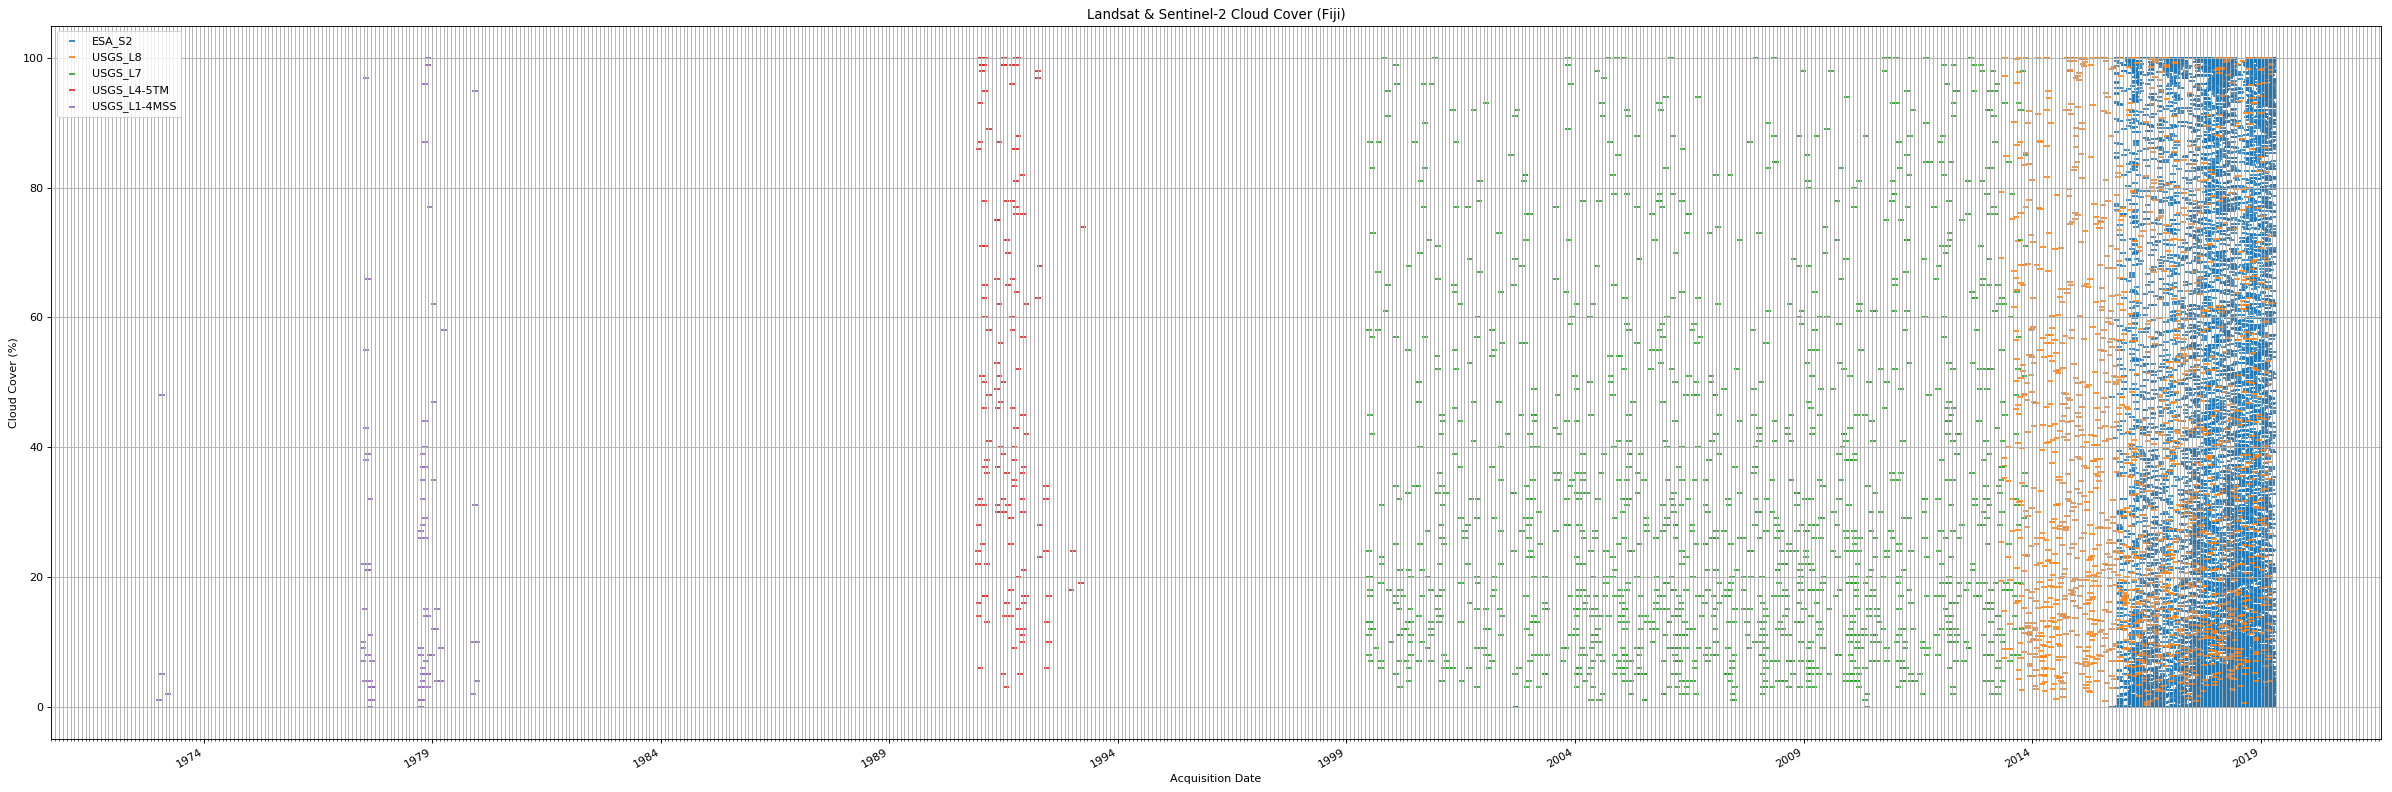

In [9]:
fig, ax = plt.subplots(figsize=(30,10),dpi=80)
fig.autofmt_xdate()

df = pd.read_csv('../Search_Discovery/Fiji_S2_L1C_ESA.csv')
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)
ax.scatter(df['Acquisition Date'].values, df['cloudcoverpercentage'].values, marker='_');

df = pd.read_csv('../Search_Discovery/USGS_Landsat/LANDSAT_8_C1_fiji.csv')
df['Acquisition Date'] = pd.to_datetime(df['acquisitionDate'], format='%Y-%m-%d', utc=True)
ax.scatter(df['Acquisition Date'].values, df['cloudCover'].values, marker='_');
df = pd.read_csv('../Search_Discovery/USGS_Landsat/LANDSAT_ETM_C1_fiji.csv')
df['Acquisition Date'] = pd.to_datetime(df['acquisitionDate'], format='%Y-%m-%d', utc=True)
ax.scatter(df['Acquisition Date'].values, df['cloudCover'].values, marker='_');
df = pd.read_csv('../Search_Discovery/USGS_Landsat/LANDSAT_TM_C1_fiji.csv')
df['Acquisition Date'] = pd.to_datetime(df['acquisitionDate'], format='%Y-%m-%d', utc=True)
ax.scatter(df['Acquisition Date'].values, df['cloudCover'].values, marker='_');
df = pd.read_csv('../Search_Discovery/USGS_Landsat/LANDSAT_MSS_C1_fiji.csv')
df['Acquisition Date'] = pd.to_datetime(df['acquisitionDate'], format='%Y-%m-%d', utc=True)
ax.scatter(df['Acquisition Date'].values, df['cloudCover'].values, marker='_');

ax.set_ylabel("Cloud Cover (%)");
ax.set_xlabel("Acquisition Date");
ax.legend(['ESA_S2','USGS_L8','USGS_L7','USGS_L4-5TM','USGS_L1-4MSS']);
ax.set_title('Landsat & Sentinel-2 Cloud Cover (Fiji)');
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y") ) 
ax.xaxis.set_minor_locator(mdates.MonthLocator())
#ax.xaxis.set_minor_formatter(DateFormatter("%m") ) 
ax.grid(which='both')
fig.tight_layout()
fig.savefig('../Search_Discovery/LS_Summary_CC_AqNo');

### **Data Ordering:** USGS
We can use the USGS ESPA JSON REST API to automatically order Landsat data as USGS-defined ARD. This de-risks any Common Sensing investment into Landsat ARD processing becoming redundant as USGS disseminate ARD routinely for new acquistions in the tail end of 2019.
- Max 10,000 product orders per user
- Real time (RT) products cannot be processed, Tier 1 (T1) and Tier 2 (T2) only.
- Reasonably turn around of <1 day for full archive of single frame comprising >300 acquisitions.

Here we provide the method used to obtain Landsat 4-8 ARD for the Common Sensing initial PoC.

First we subset the available data to just the desired Landsat frame (path/row) and check we're not requesting a ridiculous no....

In [751]:
plist = ['']
rlist = ['']

df = pd.read_csv('../Search_Discovery/USGS_Landsat/LANDSAT_8_C1_fiji.csv')
df = df[df.row.isin(['72'])&df.path.isin(['74'])]
l8_list = list(df.LANDSAT_PRODUCT_ID.values)
print(len(l8_list))
df = pd.read_csv('../Search_Discovery/USGS_Landsat/LANDSAT_ETM_C1_fiji.csv')
df = df[df.row.isin(['72'])&df.path.isin(['74'])]
l7_list = list(df.LANDSAT_PRODUCT_ID.values)
print(len(l7_list))
df = pd.read_csv('../Search_Discovery/USGS_Landsat/LANDSAT_TM_C1_fiji.csv')
df = df[df.row.isin(['72'])&df.path.isin(['74'])]
l4_list = list(df.LANDSAT_PRODUCT_ID.values)
print(len(l4_list))
df = pd.read_csv('../Search_Discovery/USGS_Landsat/LANDSAT_MSS_C1_fiji.csv')
df = df[df.row.isin(['72'])&df.path.isin(['74'])]
l1_list = list(df.LANDSAT_PRODUCT_ID.values)
len(l1_list)

# drop a file that raised an error in the request
drop = 'LC08_L1TP_074072_20160222_20170329_01_T1'  
print(len(l8_list))
not_found = []
for i in l8_list:
    if i not in drop:
        not_found.append(i)
print(len(not_found))
l8_list = not_found

134
155
16
134
133


In [5]:
# function for basic interaction with ESPA API - hacked together from their 'how to page'
def espa_api(endpoint, verb='get', body=None, uauth=None):
    """ Suggested simple way to interact with the ESPA JSON REST API """
    auth_tup = uauth if uauth else (username, password)
    response = getattr(requests, verb)(host + endpoint, auth=auth_tup, json=body)
    print('{} {}'.format(response.status_code, response.reason))
    data = response.json()
    if isinstance(data, dict):
        messages = data.pop("messages", None)  
        if messages:
            print(json.dumps(messages, indent=4))
    try:
        response.raise_for_status()
    except Exception as e:
        print(e)
        return None
    else:
        return data

In [6]:
# earth explorer credentials are required
host = 'https://espa.cr.usgs.gov/api/v1/'
username = 'tom.jones'
password = 'Welcome12'

# check login
print('GET /api/v1/user')
resp = espa_api('user')
print(json.dumps(resp, indent=4))

GET /api/v1/user
301 Moved Permanently


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [750]:
### CHECK CONFLICTING ORDERS ###

# check for any existing orders that may prevent imediate processing of a fresh requestttttt
print('GET /api/v1/list-orders')
filters = {"status": ["complete", "ordered"]}  # Here, we ignore any purged orders
resp = espa_api('list-orders', body=filters)
print(json.dumps(resp, indent=4))

GET /api/v1/list-orders
200 OK
[]


In [749]:
### CHECK PRODUCT AVAILABILITY ###

# example of how to check available products for desired scenes
print('GET /api/v1/available-products')
avail_list = {'inputs': l8_list[8:10]
             }
resp = espa_api('available-products', body=avail_list)
print(json.dumps(resp, indent=4))

GET /api/v1/available-products
200 OK
{
    "olitirs8_collection": {
        "products": [
            "source_metadata",
            "l1",
            "toa",
            "bt",
            "sr",
            "sr_ndvi",
            "sr_evi",
            "sr_savi",
            "sr_msavi",
            "sr_ndmi",
            "sr_nbr",
            "sr_nbr2",
            "stats",
            "pixel_qa",
            "stalg_split_window",
            "stalg_single_channel",
            "reanalsrc_narr",
            "reanalsrc_merra2",
            "reanalsrc_fp",
            "reanalsrc_fpit"
        ],
        "inputs": [
            "LC08_L1TP_074072_20181110_20181127_01_T1",
            "LC08_L1GT_074072_20181025_20181114_01_T2"
        ]
    }
}


In [109]:
### CREATE ORDER ###
# if any further subsetting is required. very recently acquired products are categorised as RT (as opposed to T1/T2). these are of insufficient certainty RE quality to be processed to ARD. this latency is unlikely to impact the non-NRT requirements of Common Sensing.
l8_ls = l8_list[8:]
l7_ls = l7_list
l4_ls = l4_list

# specifying differing products across the sensors
l8_prods = ["sr","bt","source_metadata","sr_ndvi","sr_evi","sr_savi","sr_msavi","sr_ndmi","sr_nbr","sr_nbr2","stats","pixel_qa"]
l7_prods = ["sr","bt","source_metadata","sr_ndvi","sr_evi","sr_savi","sr_msavi","sr_ndmi","sr_nbr","sr_nbr2","stats","pixel_qa"]
l4_prods = ["sr","bt","source_metadata","sr_ndvi","sr_evi","sr_savi","sr_msavi","sr_ndmi","sr_nbr","sr_nbr2","stats","pixel_qa"]
         
# optional definition of projection. TBD whether possible to request directly within Fiji Map Grid.
#projection = {'aea': {'standard_parallel_1': 29.5,
#                      'standard_parallel_2': 45.5,
#                      'central_meridian': -96.0,
#                      'latitude_of_origin': 23.0,
#                      'false_easting': 0,
#                      'false_northing': 0,
#                      'datum': 'nad83'}}

# determine available-products under their respective sensors
ls = l8_ls + l7_ls + l4_ls
print('GET /api/v1/available-products')
order = espa_api('available-products', body=dict(inputs=ls))
print(json.dumps(order, indent=4))

# replace available products with what we wish to process
for sensor in order.keys():
    if isinstance(order[sensor], dict) and order[sensor].get('inputs'):
        if set(l7_ls) & set(order[sensor]['inputs']):
            order[sensor]['products'] = l7_prods
        if set(l8_ls) & set(order[sensor]['inputs']):
            order[sensor]['products'] = l8_prods
        if set(l4_ls) & set(order[sensor]['inputs']):
            order[sensor]['products'] = l4_prods

# Add in the rest of the order information
#order['projection'] = projection
order['format'] = 'gtiff'
order['resampling_method'] = 'cc'
order['note'] = 'CS Demo!!!'

# the order shoud now have changed from the original call available-products
print(json.dumps(order, indent=4))

GET /api/v1/available-products
200 OK
{
    "etm7_collection": {
        "inputs": [
            "LE07_L1GS_074072_20131104_20161205_01_T2",
            "LE07_L1GS_074072_20130917_20170911_01_T2",
            "LE07_L1GS_074072_20130901_20161205_01_T2",
            "LE07_L1TP_074072_20130816_20161122_01_T1",
            "LE07_L1TP_074072_20130731_20161122_01_T1",
            "LE07_L1TP_074072_20130715_20161123_01_T1",
            "LE07_L1GS_074072_20130629_20161123_01_T2",
            "LE07_L1GS_074072_20130512_20161125_01_T2",
            "LE07_L1GS_074072_20130410_20161125_01_T2",
            "LE07_L1TP_074072_20130325_20161124_01_T1",
            "LE07_L1GS_074072_20130309_20161125_01_T2",
            "LE07_L1GS_074072_20130205_20161126_01_T2",
            "LE07_L1GS_074072_20130120_20161126_01_T2",
            "LE07_L1GS_074072_20130104_20161126_01_T2",
            "LE07_L1GS_074072_20121219_20161127_01_T2",
            "LE07_L1TP_074072_20121203_20161127_01_T1",
            "LE07_L

In [112]:
### PLACE ORDER ###
print('POST /api/v1/order')
resp = espa_api('order', verb='post', body=order)
print(resp.keys)
print(json.dumps(resp, indent=4))

POST /api/v1/order
201 CREATED
<built-in method keys of dict object at 0x7fad0b5b7ea0>


In [114]:
### CHECK STATUS OF ORDER ### 
orderid = resp['orderid']
print('GET /api/v1/order-status/{}'.format(orderid))
resp = espa_api('order-status/{}'.format(orderid))
print(json.dumps(resp, indent=4))

GET /api/v1/order-status/espa-tom.jones@sa.catapult.org.uk-04102019-045224-869
200 OK
{
    "orderid": "espa-tom.jones@sa.catapult.org.uk-04102019-045224-869",
    "status": "ordered"
}


In [115]:
### EXTRACT URLS ###
urls = []
for item in resp[orderid]:
    urls.append(item.get('product_dload_url'))
print(urls)

GET /api/v1/item-status/espa-tom.jones@sa.catapult.org.uk-04102019-045224-869
200 OK
[]


## Landsat Estimated ARD Data Volumes

- list of essential classification bands
- list of 'useful' classification bands + additional products
- **storage implications from ordering additional products** (i.e. ndvi) that could add value to Common Sensing functionality and reduce computational costs later on - is this worth it??

# Helper Functions
To be moved to separate python script eventually. Along with major plotting functions.

In [3]:
## Function to reproject wkt eometry from wgs84 into Fiji local coordinate system

def reproject(wkt):
    
    source = osr.SpatialReference()
    source.ImportFromEPSG(4326)

    target = osr.SpatialReference()
    target.ImportFromEPSG(3460)

    transform = osr.CoordinateTransformation(source, target)

    polygon = ogr.CreateGeometryFromWkt(str(wkt))
    polygon.Transform(transform)

    return polygon.ExportToWkt()



In [4]:
# old code for reading full path row shapefile - not needed since path rows manually subsetted in QGIS due to anti-meridian issues...
pr_gdf = geopandas.read_file('../Search_Discovery/USGS_Landsat/WRS2_descending.shp', driver='shapefile', geometry='geometry', crs=('epsg:4326'))
#pr_gdf.head(2)

TypeError: open() got an unexpected keyword argument 'geometry'